<a href="https://colab.research.google.com/github/michelleaeh/ADissertation/blob/master/33MScCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project:** MSc in Robotics and Intelligent Systems Dissertation

**Author:** Michelle Alejandra Espinosa Hernandez

**Student registration number:** 1900964

**Student PRID:** ESPIN62803

**Date:** September 2020 

**Purpose:** Obtain classification accuracy among different types of sensors and different data processing steps

# **Data description**

**Myo armband dataset from https://data.mendeley.com/datasets/wgswcr8z24/2**


The dataset consits of .csv files collected from two Myo armbands. The format of the files are [word_name]_[id]. The ‘word_name’ is the English translation of the American Sign Language word used and the ‘id’ is a unique identifier. The .zip for each of the above links has sub-folders for each User.

Each file has 50 columns. They represent a sub-sampled data collection from two Myo devices worn on left and right hands of the signer. The first column is the ‘Counter’ that goes from 1 to 50.

The following columns are of the format: [Sensor][pod/direction][left/right]. For instance the EMG reading for the first EMG pod (out of 8) on the left hand would be called EMG0R and the accelerometer reading for the Z axis on the left hand would be called: AXL

If you use this dataset please cite the following papers:

@inproceedings{paudyal2016sceptre,
title={Sceptre: a pervasive, non-invasive, and programmable gesture recognition technology},
author={Paudyal, Prajwal and Banerjee, Ayan and Gupta, Sandeep KS},
booktitle={Proceedings of the 21st International Conference on Intelligent User Interfaces},
pages={282--293},
year={2016},
organization={ACM}
}

@inproceedings{paudyal2017dyfav,
title={Dyfav: Dynamic feature selection and voting for real-time recognition of fingerspelled alphabet using wearables},
author={Paudyal, Prajwal and Lee, Junghyo and Banerjee, Ayan and Gupta, Sandeep KS},
booktitle={Proceedings of the 22nd International Conference on Intelligent User Interfaces},
pages={457--467},
year={2017},
organization={ACM}
}

**Frequency:**

50Hz sampling rate

**Words:**

*36 total words*

allmorning, bird, blue, cantsleep, cat, colrunnynose, continuouslyforanhour, cost, day, dollar, everymorning, everynight, gold, goodnight, happy, headache, home, horse, hot, hurt, itching, large, mom, monthly, notfeelgood, orange, pizza, please, shirt, soreness, swelling, takeliquidmedicine, thatsterrible, tired, upsetstomach, wash


**Filenames:**

*849 total files*

(word)_(user#)(try#)


**Columns of files:**

Counter  (1 -> 50)

EMG0L -> EMG7L  (EMG sensor readings)

AXL, AYL, AZL  (accelerometer readings)

GXL, GYL, GZL  (gyroscope readings)

ORL, OPL, OYL  (magnetometer readings?)

EMG0R -> EMG7R  (EMG sensor readings)

AXR, AYR, AZR  (accelerometer readings)

GXR, GYR, GZR  (gyroscope readings)

ORR, OPR, OYR  (magnetometer readings?)

features=['EMG0L', 'EMG1L', 'EMG2L', 'EMG3L', 'EMG4L', 'EMG5L', 'EMG6L', 'EMG7L', 'AXL', 'AYL', 'AZL', 'GXL', 'GYL', 'GZL', 'ORL', 'OPL', 'OYL', 'EMG0R', 'EMG1R', 'EMG2R', 'EMG3R', 'EMG4R', 'EMG5R', 'EMG6R', 'EMG7R', 'AXR', 'AYR', 'AZR', 'GXR', 'GYR', 'GZR', 'ORR', 'OPR', 'OYR']


**Size of files:**

All files are 50 rows x 35 columns except continuouslyforanhour_22.csv, headache_52.csv, home_61.csv, and mom_82.csv which are 101 rows x 35 columns

**Steps:**

1. Combine files
2. Normalize or standardize matrix
3. Apply Butterworth
4. Apply PCA
5. Input to SVM


# **Variable definition**

In [1]:
numreps=33      # Number of epochs per word
num_trials=10  # Number of runs of cross validation


# **1. Preparation of data**

**1.1. Start up and initialization of variables**

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pandas as pd
import random
import scipy as sp
import time
import warnings

from collections import Counter
from google.colab import files
from mpl_toolkits import mplot3d
from scipy import signal
from scipy.io import loadmat
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from zipfile import ZipFile

# Start timer
starttime = time.time()

# Eliminate warnings
warnings.filterwarnings("ignore")

# Extract all files from zip
with ZipFile("/content/2MyoASL.zip", 'r') as zip:
  zip.extractall()

# Division of sensors
emg=['EMG0L', 'EMG1L', 'EMG2L', 'EMG3L', 'EMG4L', 'EMG5L', 'EMG6L', 'EMG7L', 
     'EMG0R', 'EMG1R', 'EMG2R', 'EMG3R', 'EMG4R', 'EMG5R', 'EMG6R', 'EMG7R']
acc=['AXL', 'AYL', 'AZL', 'AXR', 'AYR', 'AZR']
gyro=['GXL', 'GYL', 'GZL', 'GXR', 'GYR', 'GZR']
ori=['ORL', 'OPL', 'OYL', 'ORR', 'OPR', 'OYR']
colnames=emg[:8]+acc[:3]+gyro[:3]+ori[:3]+emg[8:]+acc[3:]+gyro[3:]+ori[3:]

# Words
words=['allmorning', 'bird', 'blue', 'cantsleep', 'cat', 'coldrunnynose', 'continuouslyforanhour', 'cost', 'day', 
       'dollar', 'everymorning', 'everynight', 'gold', 'goodnight', 'happy', 'headache', 'home', 'horse', 'hot', 
       'hurt', 'itching', 'large', 'mom', 'monthly', 'notfeelgood', 'orange', 'pizza', 'please', 'shirt', 
       'soreness', 'swelling', 'takeliquidmedicine', 'thatsterrible', 'tired', 'upsetstomach', 'wash']

# Generation of matrices
### Combinations of sensors (E=emg=3, A=acc=5, G=gyro=7, O=ori=11)
comb=['E', 'A', 'G', 'O', 'EA', 'EG', 'EO', 'AG', 'AO', 'GO', 'EAG', 'EAO', 'EGO', 'AGO', 'EAGO'] 
products=[3, 5, 7, 11, 15, 21, 33, 35, 55, 77, 105, 165, 231, 385, 1155] 
### Combinations of steps (N=Normalization=3, S=Standardization=5, B=Butterworth=7, P=PCA=11, V=SVM=13)
nsteps=['V', 'NV', 'SV', 'BV', 'PV', 'NBV', 'NPV', 'SBV', 'SPV', 'BPV', 'NBPV', 'SBPV'] 
steps=[13, 39, 65, 91, 143, 273, 429, 455, 715, 1001, 3003, 5005] 
### Placeholders
fresults=np.zeros((len(steps),len(products)))
params=np.zeros((len(steps),len(products)))
headers=np.empty(1701, dtype=object)
lengths=np.zeros(849, dtype=int)
repsum=np.zeros(37,dtype=int)
reps=np.zeros(36,dtype=int)
features=np.zeros(15)
target=np.zeros(15)
fn=np.arange(1701)
matrix=np.zeros(1)
stanproducts=[]
normproducts=[]
regproducts=[]
cmatrix=[]

# Initiation of counters
wordnum=-1
counter=-1
rownum=-1
start=0
num=0
n=0

**1.2. Combine all files**

In [3]:
for w in words:
  repcount=0
  wordnum+=1
  for i in range (10, 120):
    path='/content/2MyoASL/' + w + '_' + str(i) + '.csv'
    if os.path.exists(path)==True:
      counter+=1
      repcount+=1
      trial=pd.read_csv(path)
      trial.reset_index(drop=True)
      
      # Assign word number to each row and make data horizontal
      row=np.zeros(1)
      for t in range(35):
        if t==0:
          row[0]=wordnum
        else:
          sensor=trial.iloc[0:50,t].values
          sensor.reshape([1,50])
          row=np.concatenate((row, sensor))
      prev=row
      
      # Combine all trials
      if counter==0:
        matrix=prev
      else:
        matrix=np.concatenate([matrix,prev])

  reps[wordnum]=repcount
  if wordnum>0:
    repsum[wordnum]=reps[wordnum-1]+repsum[wordnum-1]
    repsum[36]=849

# Create header name array
headers[0]='Word'
for c in colnames:
  for t in range(50):
    num+=1
    headers[num]=c

# Give format to final matrix 
matrix=matrix.reshape([849,1701])
matrix=pd.DataFrame(matrix, columns=headers)
matrix=pd.concat([matrix['Word'],matrix[emg],matrix[acc],matrix[gyro],matrix[ori]],axis=1)
exec("matrix.to_csv(path_or_buf='/content/complete_matrix_'+str(numreps)+'.csv')")
print('Reps of each word:',reps)
print('Cummulative reps:',repsum)

Reps of each word: [19 24 32 20 24 20 19 31 24 29 20 21 23 33 34 18 27 24 35 19 17 34 30 19
 22 21 23 27 27  4 20 19 20 20 21 29]
Cummulative reps: [  0  19  43  75  95 119 139 158 189 213 242 262 283 306 339 373 391 418
 442 477 496 513 547 577 596 618 639 662 689 716 720 740 759 779 799 820
 849]


**1.3. Calculate mean and standard deviation of each sensor and each file**

In [4]:
# Average and standard deviation of each sensor in each file
for s in colnames:
  avg=matrix[s].mean(axis=1)
  sd=matrix[s].std(axis=1)
  sensor=pd.concat([avg.rename(s+': Mean_'),sd.rename('St. dev.')], axis=1)
  if s=='EMG0L':
    asd=sensor
  else:
    asd=pd.concat([asd, sensor], axis=1)
print('Average and standard deviation of each sensor per file')
print(asd)

# Average and standard deviation of each file
avg=matrix.mean(axis=1)
sd=matrix.std(axis=1)
print('Average and standard deviation of each file')
pd.concat([avg.rename('Mean'),sd.rename('St. dev.')], axis=1)

Average and standard deviation of each sensor per file
     EMG0L: Mean_   St. dev.  EMG1L: Mean_  ...   St. dev.  OYR: Mean_   St. dev.
0           -2.32   8.664825         -0.80  ...  28.427609       86.70  10.529356
1           -1.80   9.544739         -4.08  ...  27.821010       85.68   6.579002
2           -3.16  13.085839         -2.32  ...  30.345736       91.88  17.358924
3           -0.82  10.123099         -3.16  ...  29.645002       88.46  12.969682
4           -0.50   6.516071          2.76  ...  13.237239      116.58  18.099600
..            ...        ...           ...  ...        ...         ...        ...
844          0.56   7.754288          0.22  ...  17.236281      104.76   7.528341
845         -1.74   6.520955         -1.20  ...  21.772891       69.66  85.251036
846          1.02   7.731436          0.46  ...  22.707735       56.76  79.408415
847          0.06   5.582078          2.36  ...  23.650422       71.62  84.238701
848         -2.22   7.434860         -1.62 

,Mean,St. dev.
0,15.256437,46.545832
1,14.220110,47.316822
2,15.441784,45.614456
3,13.651092,47.038916
4,15.063294,49.105612
...,...,...
844,13.167964,41.642351
845,13.815314,42.880121
846,12.970618,42.725653
847,13.852317,43.758631


# **2. Data adjustement**

**2.1. Establish equal number of epochs per word**

In [5]:
for i in range(len(reps)-1,-1,-1):
  if reps[i]<numreps:
    for r in range(len(matrix)-1,-1,-1):
      if int(matrix.iloc[r]['Word'])==i:
        matrix=matrix.drop(r)
  elif reps[i]>numreps:
    elim=random.sample(range(repsum[i],repsum[i+1]),reps[i]-numreps)
    matrix=matrix.drop(elim)

exec("matrix.to_csv(path_or_buf='/content/equal_matrix_'+str(numreps)+'.csv')")

**2.2. Create sensor combinatory matrices: unaltered, normalized, and standardized**

In [6]:
# Eliminate unnecessary columns to create combinatory matrices
for v in products:
  fnword=[]
  fsword=[]
  m=matrix.copy()
  if v%3!=0:
    m=m.drop(emg,1)
  if v%5!=0:
    m=m.drop(acc,1)
  if v%7!=0:
    m=m.drop(gyro,1)
  if v%11!=0:
    m=m.drop(ori,1)
  
  # Separate features from target values
  x = m.iloc[:, m.columns!='Word']   # Features

  # Create column of words instead of numbers
  wordcol=np.empty(len(m), dtype=object)
  z=0
  wcol=[int(i) for i in m['Word'].values]
  for f in wcol:
    wordcol[z]=words[f]
    z+=1
  wordcol=np.asmatrix(wordcol)
  regular=np.concatenate((np.transpose(wordcol),np.copy(m.iloc[:,1:])),axis=1)
  inputmatrix=pd.DataFrame(regular,columns=m.columns).dropna(axis=1)
  regproducts.append(inputmatrix)

  for pr in range(len(inputmatrix)):
    nemg=[]
    nacc=[]
    ngyro=[]
    nori=[]
    norm=[]
    semg=[]
    sacc=[]
    sgyro=[]
    sori=[]
    stan=[]
    if emg[0] in inputmatrix:
      in_emg=inputmatrix.iloc[pr][emg]
      nemg=(in_emg-in_emg.min())/(in_emg.max()-in_emg.min())
      is_emg=inputmatrix.iloc[pr][emg].values
      is_emg=is_emg[np.newaxis]
      semg=StandardScaler().fit_transform(np.transpose(is_emg))
      semg=semg.reshape(-1)
    if acc[0] in inputmatrix:
      in_acc=inputmatrix.iloc[pr][acc]
      nacc=(in_acc-in_acc.min())/(in_acc.max()-in_acc.min())
      is_acc=inputmatrix.iloc[pr][acc].values
      is_acc=is_acc[np.newaxis]
      sacc=StandardScaler().fit_transform(np.transpose(is_acc))
      sacc=sacc.reshape(-1)
    if gyro[0] in inputmatrix:
      in_gyro=inputmatrix.iloc[pr][gyro]
      ngyro=(in_gyro-in_gyro.min())/(in_gyro.max()-in_gyro.min())
      is_gyro=inputmatrix.iloc[pr][gyro].values
      is_gyro=is_gyro[np.newaxis]
      sgyro=StandardScaler().fit_transform(np.transpose(is_gyro))
      sgyro=sgyro.reshape(-1)
    if ori[0] in inputmatrix:
      in_ori=inputmatrix.iloc[pr][ori]
      nori=(in_ori-in_ori.min())/(in_ori.max()-in_ori.min())
      is_ori=inputmatrix.iloc[pr][ori].values
      is_ori=is_ori[np.newaxis]
      sori=StandardScaler().fit_transform(np.transpose(is_ori))
      sori=sori.reshape(-1)
    
    ## Normalize each type of sensor per sample between 0 and 1
    norm=np.concatenate((np.transpose(nemg),np.transpose(nacc),np.transpose(ngyro),np.transpose(nori)))
    norm=norm[np.newaxis]
    fnword=np.append(fnword,norm)
    fnword=fnword[np.newaxis]
    
    ## Standardize each type of sensor with mean=0 and deviation=1
    stan=np.concatenate((np.transpose(semg),np.transpose(sacc),np.transpose(sgyro),np.transpose(sori)))
    stan=stan[np.newaxis]
    fsword=np.append(fsword,stan)
    fsword=fsword[np.newaxis]

  nmx=np.reshape(fnword,(len(inputmatrix),len(inputmatrix.columns)-1))
  norm_matrix=np.concatenate((np.transpose(wordcol),nmx),axis=1) 
  norm_matrix=pd.DataFrame(norm_matrix,columns=inputmatrix.columns).dropna(axis=1)
  normproducts.append(norm_matrix)
  exec("norm_matrix.to_csv(path_or_buf='/content/norm_matrix_'+str(numreps)+'.'+str(v)+'.csv')")

  smx=np.reshape(fsword,(len(inputmatrix),len(inputmatrix.columns)-1))
  stan_matrix=np.concatenate((np.transpose(wordcol),smx),axis=1) 
  stan_matrix=pd.DataFrame(stan_matrix,columns=inputmatrix.columns).dropna(axis=1)
  stanproducts.append(stan_matrix)
  exec("stan_matrix.to_csv(path_or_buf='/content/stan_matrix_'+str(numreps)+'.'+str(v)+'.csv')")


# **3. Definition of functions for steps**

**3.1. Split data into train and test sets**

In [7]:
def datasplit(inmatrix_p):
    x = inmatrix_p.iloc[:, inmatrix_p.columns!='Word']   # Features
    y = inmatrix_p.loc[:,'Word']                         # Target
    x_train_p, x_test_p, y_train_p, y_test_p = train_test_split(x, y, test_size=0.3)
    return x_train_p, x_test_p, y_train_p, y_test_p

**3.2. Butterworth**

In [8]:
def butterworth(inmatrix_b):
  fs_nyq=50/2
  b, a = sp.signal.butter(8, 20/fs_nyq, btype='highpass', fs=fs_nyq)
  if emg[0] in inmatrix_b:
    for r in range(len(inmatrix_b)):
      in_emg=inmatrix_b.iloc[r][emg].values
      emg_filtered = sp.signal.lfilter(b, a, in_emg)
      emg_filtered=emg_filtered[np.newaxis]
      inmatrix_b.iloc[r,1:len(np.transpose(emg_filtered))+1]=emg_filtered
  return inmatrix_b

**3.3. PCA**

In [9]:
def pca(x_train_c, x_test_c, y_train_c, y_test_c):
  #pca = PCA(n_components=min(len(x_train_c), len(y_train_c)))
  print('PCA inputs')
  print(x_train_c)
  print(x_test_c)
  print(y_train_c)
  print(y_test_c)
  pca = PCA()
  pca.fit(x_train_c)
  x_t_train_pca = pca.transform(x_train_c)
  x_t_test_pca = pca.transform(x_test_c)
  return x_train_c, x_test_c, y_train_c, y_test_c, x_t_train_pca, x_t_test_pca

In [10]:
a=[[1,2,3],[4,5,6]]
print(len(a[0]))

3


**3.4. SVM with Grid Search**

In [11]:
def svm(x_train_s, x_test_s, y_train_s, y_test_s, x_t_train_s, x_t_test_s,combo):
    #parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[0.1, 1, 10, 100, 1000]}
    svc = SVC(max_iter=1000)
    nested_scores=np.zeros(num_trials)
    for t in range(num_trials):
      inner_cv=KFold(n_splits=10,shuffle=True,random_state=i)
      outer_cv=KFold(n_splits=10,shuffle=True,random_state=i)
      #clf=GridSearchCV(svc,parameters,scoring='accuracy',n_jobs=1,cv=outer_cv)
      clf=svc
      clf.fit(x_t_train_s, y_train_s)
      nested_scores=cross_val_score(clf,x_t_test_s,y_test_s,cv=outer_cv)
      nested_scores[i]=nested_scores.mean()
    y_pred=clf.predict(x_t_test_s)
    
    # Confusion matrix
    plot_confusion_matrix(clf, x_t_test_s, y_test_s, cmap=plt.cm.Blues)
    plt.title(combo)
    plt.show()

    #bestpar=clf.best_params_
    accuracy=nested_scores.mean()
    svmresult=classification_report(y_test_s, y_pred)
    #return svmresult,accuracy, bestpar
    return svmresult,accuracy

# **4. Main code**

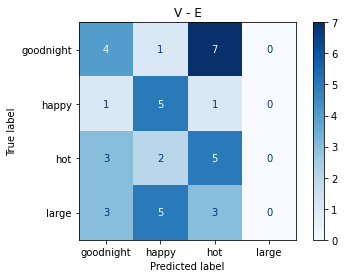

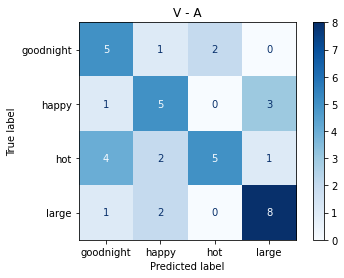

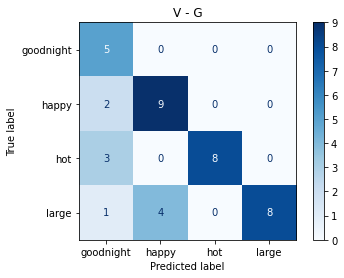

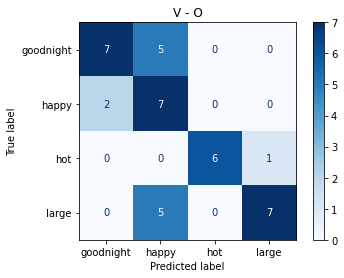

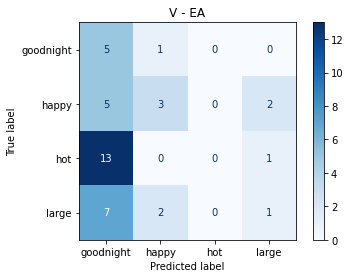

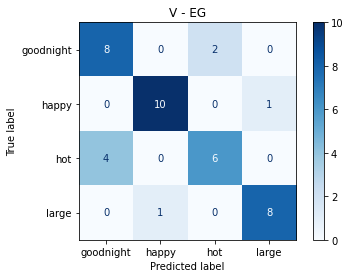

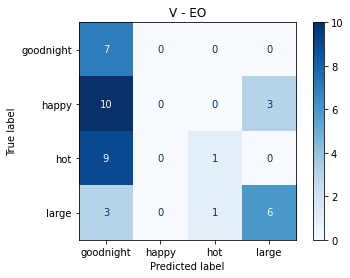

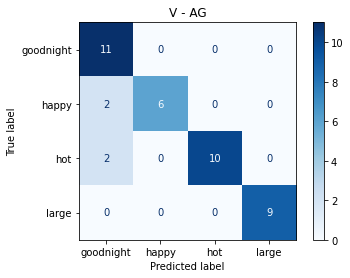

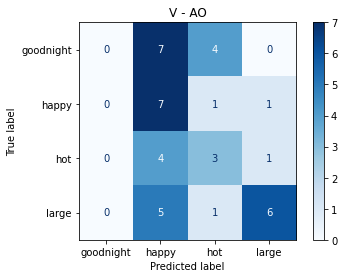

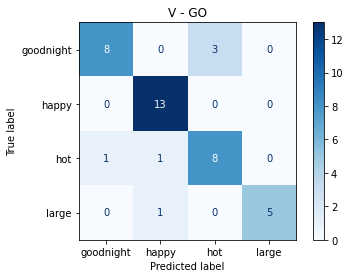

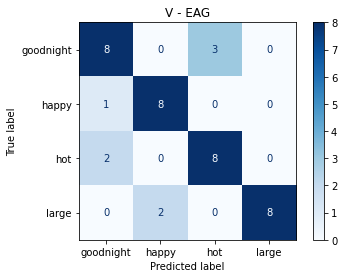

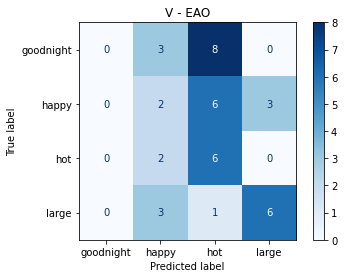

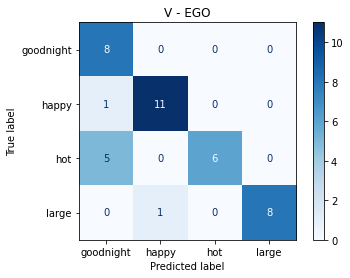

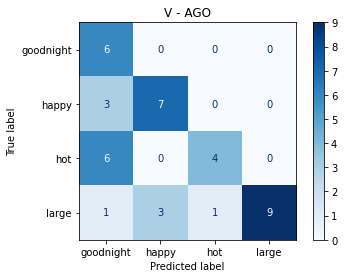

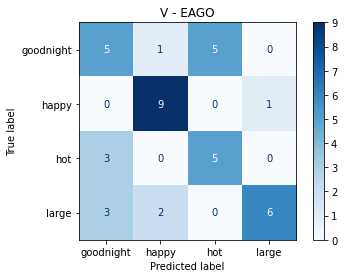

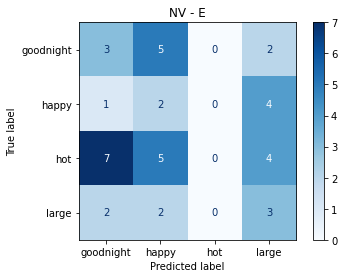

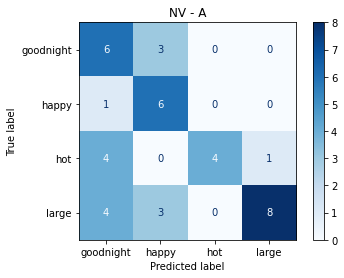

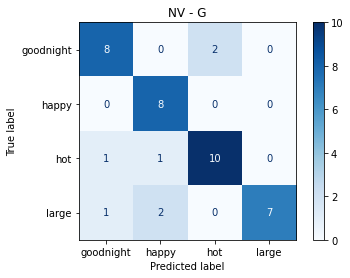

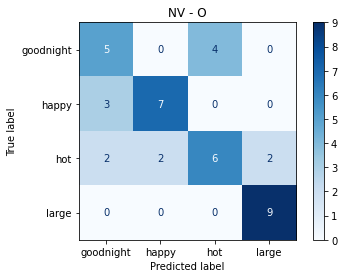

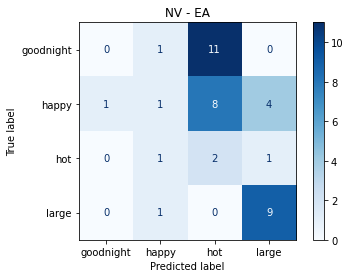

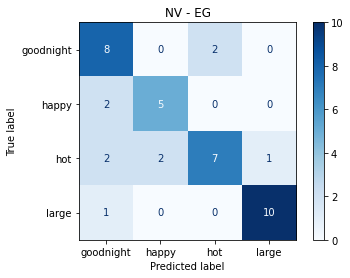

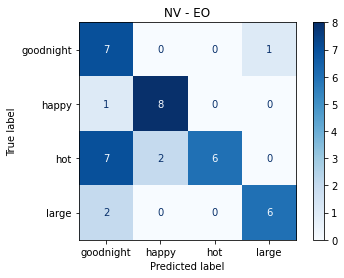

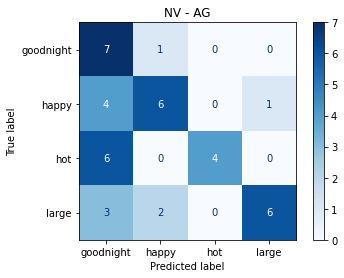

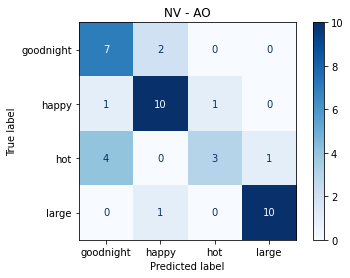

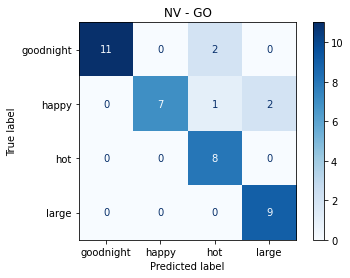

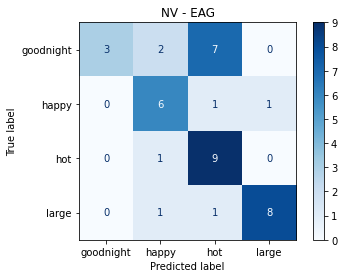

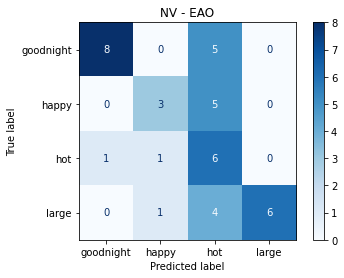

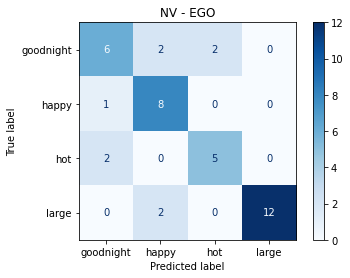

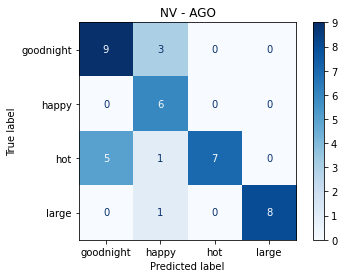

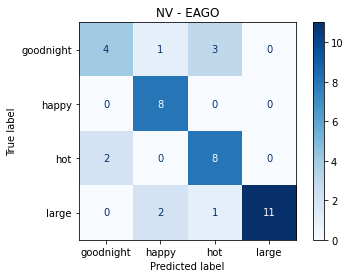

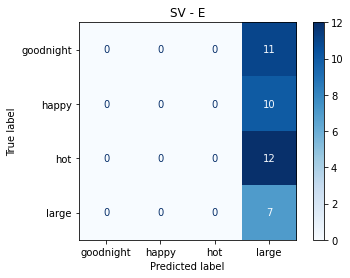

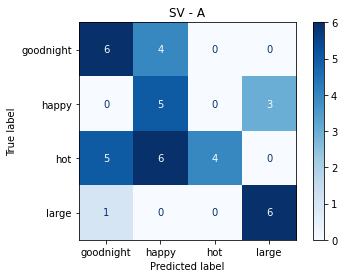

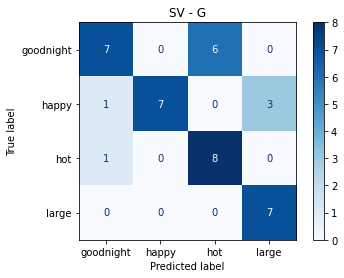

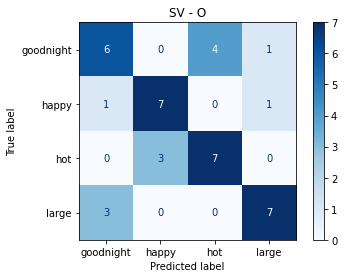

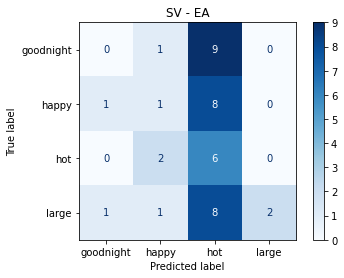

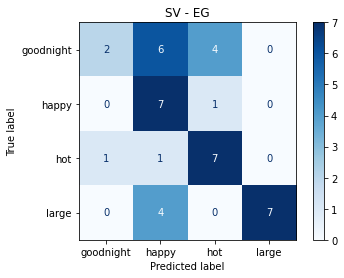

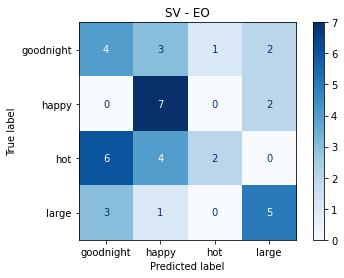

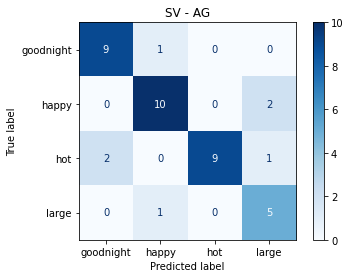

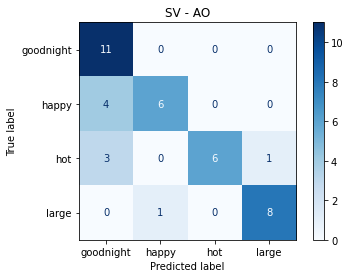

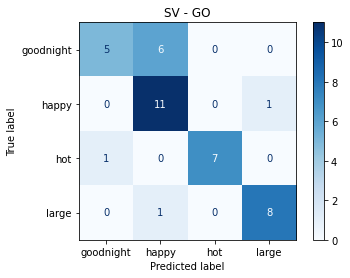

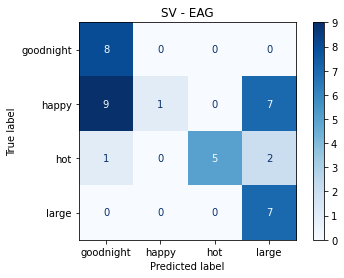

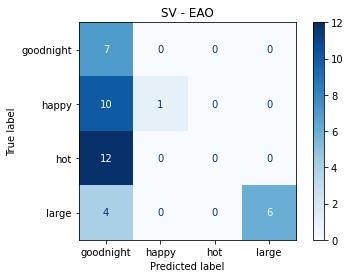

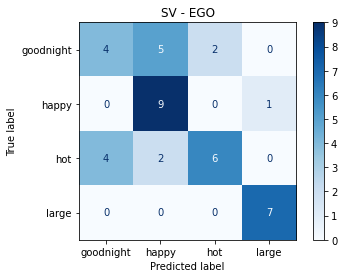

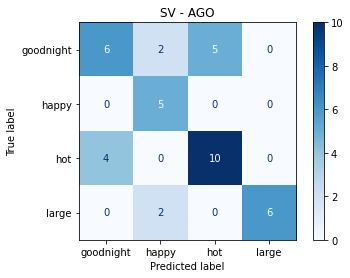

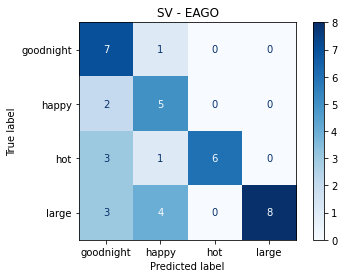

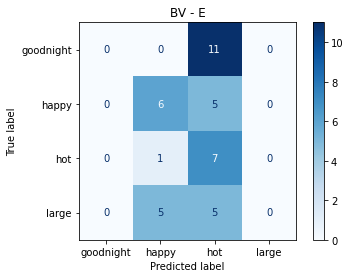

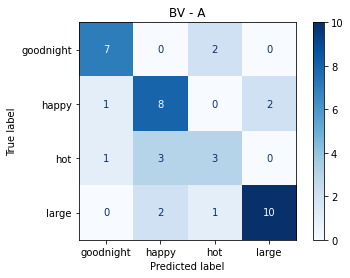

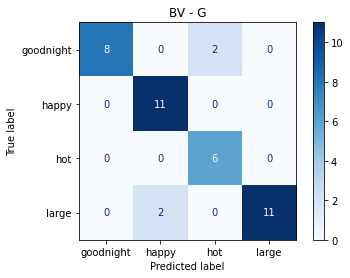

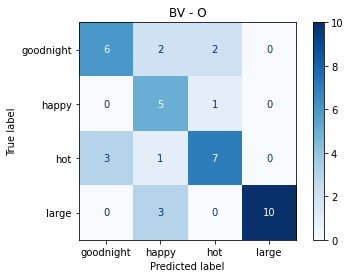

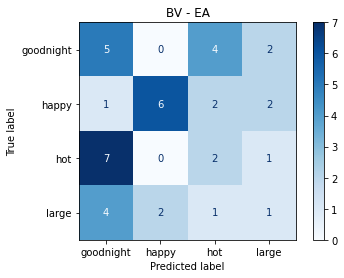

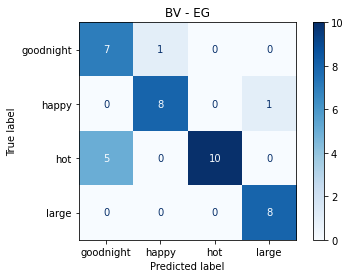

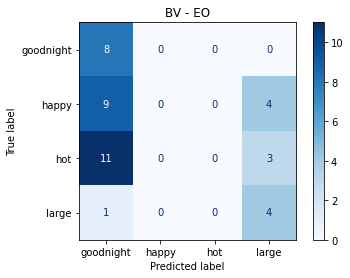

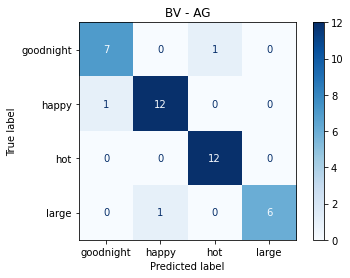

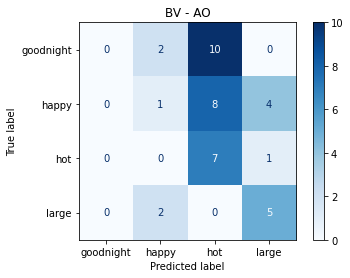

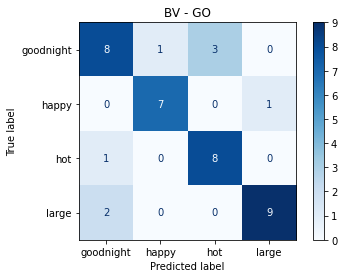

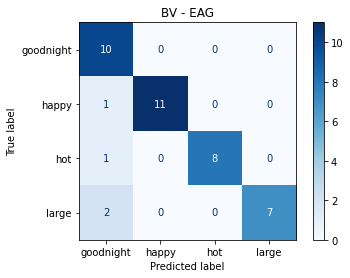

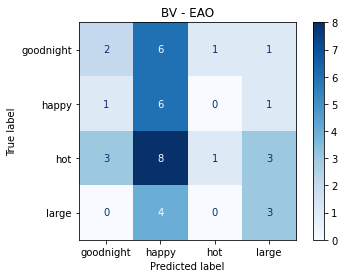

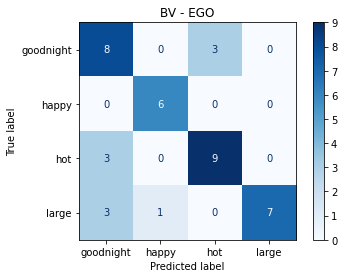

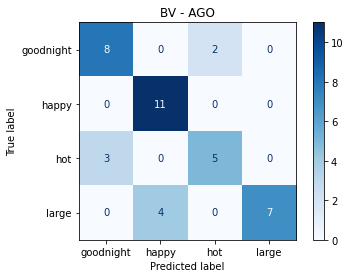

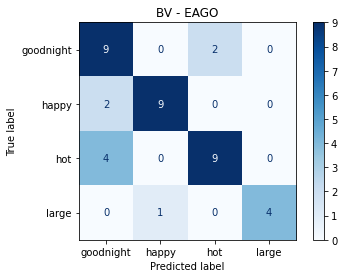

PCA inputs
    EMG0L EMG0L     EMG0L      EMG0L  ...      EMG7R     EMG7R     EMG7R     EMG7R
45      0     0   1.78993    19.6348  ...   -3.67344  -14.7702  -2.96951 -0.297262
67      0     0 -0.596644  0.0181533  ...    1.44433   3.62352  -7.83289  -4.91679
129     0     0   6.56309   -4.37619  ...     2.5544 -0.996325 -0.565879  -1.90369
91      0     0 -0.596644   0.614797  ...    6.92146    1.8727  -2.03116   4.53632
6       0     0  -5.96644   -3.39833  ... -0.0669126  -1.26879  -1.43853   0.74791
..    ...   ...       ...        ...  ...        ...       ...       ...       ...
68      0     0  -1.19329  0.0363065  ...    17.0481   13.3442   9.61098   4.15938
109     0     0    26.849  -0.816897  ...    4.54741  -5.81861  -7.28914   3.98722
3       0     0  -1.19329    1.82624  ...   -1.10908  -1.58268  -2.32685  -1.62923
25      0     0  -4.17651      12.06  ...   -2.67277   1.20762  0.649705 -0.739174
86      0     0  -1.19329  0.0363065  ...    4.55154   5.22025   5.63974   6

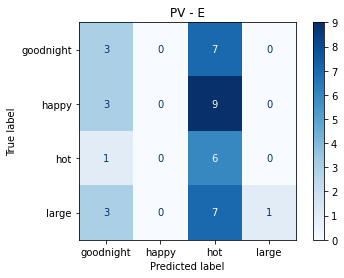

PCA inputs
            AXL         AXL        AXL  ...       AZR       AZR       AZR
49    -0.297852   -0.295898  -0.294434  ...  0.955078  0.964844  0.949707
43    -0.170898     0.10791   0.236816  ...  0.958496  0.966309  0.969727
66    -0.552734   -0.534668  -0.541992  ...  0.859375  0.865234  0.866699
37     0.744629    0.700195    0.32373  ...  0.758789  0.742188  0.743164
109    0.258789    0.327637   0.472168  ...  0.702637  0.708496  0.708984
..          ...         ...        ...  ...       ...       ...       ...
70     0.519531    0.541504    0.53125  ...   1.00928  0.998535   0.96582
122    0.090332     0.15332   0.257324  ...   1.03711   1.04248  0.962891
14   -0.0512695  -0.0703125  -0.129395  ...   1.00195   1.01025   1.00781
130   -0.791504   -0.805664  -0.422852  ...   1.09082    1.1377   1.08594
56  -0.00634766  0.00244141 -0.0366211  ...   1.04443   1.31689   1.25488

[92 rows x 300 columns]
            AXL        AXL         AXL  ...       AZR       AZR       AZR
90

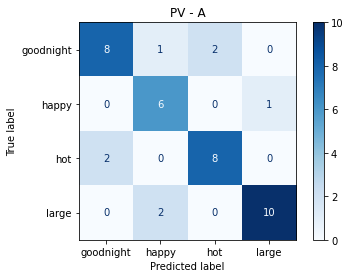

PCA inputs
         GXL      GXL      GXL      GXL  ...      GZR      GZR      GZR      GZR
22     0.125   0.3125   -0.125      2.5  ...  -49.875  -67.875 -85.5625 -107.438
67     -1.25   2.4375    4.625   9.4375  ... -43.8125 -35.3125 -23.5625    -7.25
27   -0.4375  -0.4375   0.1875  -0.6875  ...    5.375   5.4375   0.6875   -5.875
44     2.875 -13.5625       -9   -1.375  ...    0.125   -0.125   0.5625   0.3125
12   15.9375  43.9375  19.5625   -28.25  ...       15   6.4375  -1.4375   5.6875
..       ...      ...      ...      ...  ...      ...      ...      ...      ...
105      8.5   1.5625      3.5     -1.5  ...  129.062  116.125  89.0625  27.1875
86   -2.1875  -3.4375     -3.5  -0.9375  ...     43.5  33.1875  11.9375  -0.5625
34        59   52.625   84.875  61.3125  ... -16.8125   -22.75   -21.75  -24.875
127  -0.5625    -2.25  34.5625  14.1875  ...   36.375     6.25     2.75   0.1875
61    0.1875   0.4375  -2.9375  -6.0625  ...  -56.875   -34.25 -17.4375 -22.8125

[92 rows x 300 c

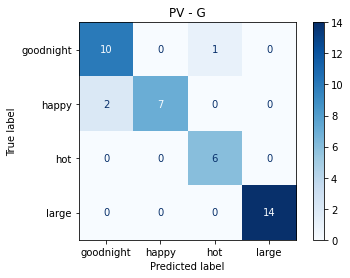

PCA inputs
    ORL ORL ORL ORL ORL ORL ORL ORL  ...  OYR  OYR  OYR  OYR  OYR  OYR  OYR  OYR
31   79  78  77  78  79  79  79  79  ...   81   81   81   81   81   81   81   81
19   63  63  63  64  64  65  66  66  ...  167  165  161  158  157  155  154  153
120  69  70  75  79  82  85  87  88  ...  116  117  119  121  124  128  130  134
33   83  85  84  84  86  87  89  90  ...  131  130  130  129  128  128  127  127
78   91  91  91  91  91  91  91  91  ...   29   29   29   29   29   29   29   29
..   ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...  ...  ...  ...
4    95  95  93  90  85  81  78  76  ...   46   46   46   46   46   46   46   46
43   89  88  86  85  85  85  85  85  ...   77   77   77   77   77   77   77   77
108  72  74  81  81  84  87  89  90  ...  121  122  124  124  124  125  126  126
105  83  83  83  83  83  82  81  79  ...  152  158  163  169  174    0    4    6
71   79  79  79  79  79  79  79  79  ...   15   15   15   15   14   14   14   14

[92 rows x 300 c

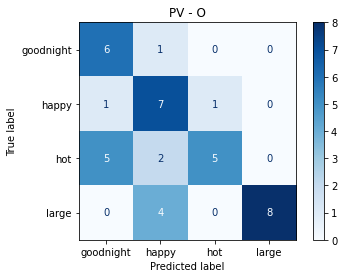

PCA inputs
    EMG0L EMG0L     EMG0L     EMG0L  ...       AZR       AZR       AZR       AZR
56      0     0 -0.596644 -0.578491  ...  0.980957   1.04443   1.31689   1.25488
6       0     0  -5.96644  -3.39833  ...  0.977051  0.973145  0.936523   0.94043
27      0     0  -1.78993  0.651104  ...  0.992188  0.989258  0.914062  0.882324
87      0     0  -1.19329  0.632951  ...  0.892578  0.836426  0.864746  0.904785
75      0     0  0.596644  -1.80809  ...   0.84668  0.835938  0.816895  0.817871
..    ...   ...       ...       ...  ...       ...       ...       ...       ...
121     0     0         0   2.98322  ...  0.819336  0.677734  0.919922  0.890137
60      0     0  -1.78993   1.84439  ...  0.956543  0.991699  0.985352   1.01025
82      0     0 -0.596644   1.21144  ...  0.802246  0.785156  0.851562  0.969727
35      0     0  -2.38658   7.23234  ...  0.939453  0.873535  0.786133  0.858398
64      0     0   1.19329  -1.22959  ...  0.946777  0.956543  0.953613  0.964844

[92 rows x 1100 

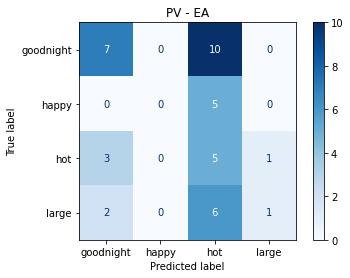

PCA inputs
    EMG0L    EMG0L     EMG0L     EMG0L  ...      GZR      GZR      GZR      GZR
62      0        0         0         0  ...  -61.375  -38.125  -44.625  -40.375
41      0        0  -1.78993   1.24775  ...        5  -1.9375   9.8125    8.625
38      0        0  -2.38658   3.65248  ...    9.875    3.375   3.8125  10.3125
69      0 -2.38658   1.86255   3.57951  ...  -0.1875    -1.75  -0.8125  -0.8125
122     0        0   5.96644  -7.93791  ... -44.0625      -35 -14.8125  -15.625
..    ...      ...       ...       ...  ...      ...      ...      ...      ...
108     0        0  -2.98322 -0.505878  ...  14.6875  19.1875   0.0625  -5.5625
10      0        0  -2.38658    1.2659  ...   2.1875  -1.8125  -2.8125  -2.1875
127     0        0  0.596644  -3.59802  ...   36.375     6.25     2.75   0.1875
91      0        0 -0.596644  0.614797  ...      7.5       -2    -9.25   1.0625
93      0        0         0         0  ...   2.6875   0.3125 -15.1875  -22.125

[92 rows x 1100 columns]
   

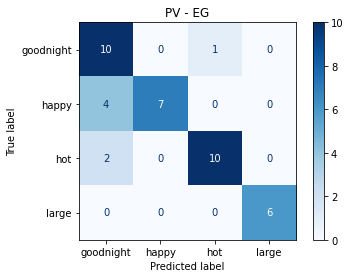

PCA inputs
    EMG0L EMG0L     EMG0L      EMG0L     EMG0L  ...  OYR  OYR  OYR  OYR  OYR
20      0     0         0          0  -1.78993  ...  160  158  156  154  153
130     0     0  -7.15973    4.99099   12.5466  ...  164  165  166  168  169
113     0     0   4.17651   -1.91701  -3.91842  ...   46   48   48   49   49
38      0     0  -2.38658    3.65248   6.50828  ...   16   16   16   16   17
32      0     0  -2.38658   -2.91061   3.72474  ...   83   83   83   83   83
..    ...   ...       ...        ...       ...  ...  ...  ...  ...  ...  ...
67      0     0 -0.596644  0.0181533 -0.284795  ...  141  139  138  137  137
88      0     0 -0.596644  -0.578491  0.330003  ...   84   84   84   84   84
127     0     0  0.596644   -3.59802   2.18365  ...  170  171  171  170  169
122     0     0   5.96644   -7.93791  -7.05901  ...   79   79   78   78   78
4       0     0  -5.96644   -3.39833   11.5804  ...   46   46   46   46   46

[92 rows x 1100 columns]
    EMG0L    EMG0L     EMG0L      EMG0L

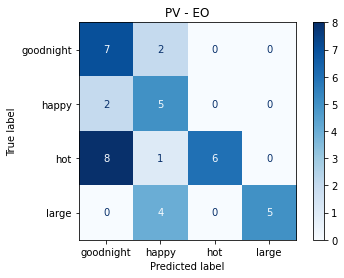

PCA inputs
           AXL        AXL       AXL  ...      GZR      GZR      GZR
94    0.753418   0.755371  0.741699  ... -16.6875 -27.5625 -33.1875
129 -0.0297852  0.0537109  0.208984  ...      3.5        2   -0.625
89   -0.194824  -0.201172 -0.192871  ...   9.6875  -7.9375  -5.1875
31   -0.679688  -0.717285   -0.6875  ...   0.6875  -1.5625   1.5625
116  -0.189941  -0.187988 -0.212402  ...  13.3125  24.1875   34.875
..         ...        ...       ...  ...      ...      ...      ...
99   -0.461426   -0.45459 -0.445801  ...     5.25  -9.4375    -13.5
115  -0.215332  0.0229492 -0.090332  ...   10.125   6.0625   6.6875
97   -0.543457  -0.534668 -0.536621  ...      -24 -23.0625  18.0625
127   0.668457   0.678711   0.70752  ...     6.25     2.75   0.1875
112  -0.245117  -0.236328  0.153809  ...  -2.6875  -0.4375  -1.8125

[92 rows x 600 columns]
            AXL         AXL         AXL  ...      GZR      GZR      GZR
58   -0.0898438      -0.125   -0.274902  ...    51.75  17.9375   -48.75
78  

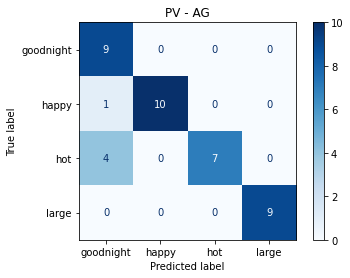

PCA inputs
           AXL        AXL       AXL          AXL  ...  OYR  OYR  OYR  OYR
57    -0.73584 -0.0708008  0.192383    0.0166016  ...  106  111  112  112
82   -0.188965  -0.190918 -0.192871    -0.195312  ...   67   66   64   62
4     0.259277   0.291992  0.496582 -0.000976562  ...   46   46   46   46
41   -0.446289  -0.457031 -0.560547    -0.792969  ...  102  102  102  102
0    -0.652832  -0.593262  -0.49707    -0.245117  ...  118  117  117  117
..         ...        ...       ...          ...  ...  ...  ...  ...  ...
21  -0.0888672 -0.0336914  0.081543    0.0991211  ...  162  160  158  156
116  -0.189941  -0.187988 -0.212402    -0.182129  ...   48   48   49   50
49   -0.297852  -0.295898 -0.294434    -0.296387  ...   65   65   65   65
8    -0.184082  -0.163086 -0.109863    -0.107422  ...   82   82   82   82
99   -0.461426   -0.45459 -0.445801    -0.459961  ...  143  144  143  143

[92 rows x 600 columns]
            AXL         AXL        AXL          AXL  ...  OYR  OYR  OYR  OYR

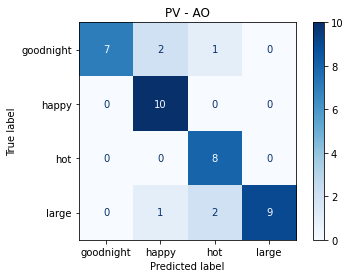

PCA inputs
         GXL      GXL      GXL      GXL      GXL  ...  OYR  OYR  OYR  OYR  OYR
82   -0.4375     -0.5   0.5625    1.875   -0.625  ...   69   67   66   64   62
14   38.5625  24.0625   9.8125  -1.9375   -7.625  ...   84   84   84   84   84
46   15.9375  51.6875 -36.9375   8.3125  -33.125  ...   68   68   68   68   68
113  -2.9375      -15  -36.125     -6.5 -28.1875  ...   46   48   48   49   49
78    2.4375    -1.75   3.3125    -2.75   1.5625  ...   29   29   29   29   29
..       ...      ...      ...      ...      ...  ...  ...  ...  ...  ...  ...
74         0     0.25  -3.1875   -2.875        1  ...  120  119  119  118  118
76     1.375    5.125   0.6875  -6.6875   5.8125  ...  123  122  122  122  122
10      79.5  112.562  79.9375   83.875  113.562  ...   85   85   85   85   85
22     0.125   0.3125   -0.125      2.5  11.5625  ...  178  177  176  174  171
8    86.6875  76.8125   48.875  42.3125       26  ...   82   82   82   82   82

[92 rows x 600 columns]
         GXL    

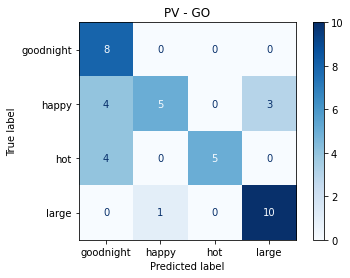

PCA inputs
    EMG0L EMG0L     EMG0L     EMG0L  ...      GZR     GZR      GZR     GZR
58      0     0   1.19329   -5.4061  ...  52.3125   51.75  17.9375  -48.75
34      0     0  -6.56309   9.14935  ... -16.8125  -22.75   -21.75 -24.875
28      0     0  0.596644 -0.614797  ... -23.0625 -24.625 -27.4375  -27.25
121     0     0         0   2.98322  ...  -7.9375  -14.75  -2.4375 -3.6875
101     0     0   5.96644  -4.35804  ...     -4.5      -2   0.5625   1.625
..    ...   ...       ...       ...  ...      ...     ...      ...     ...
127     0     0  0.596644  -3.59802  ...   36.375    6.25     2.75  0.1875
10      0     0  -2.38658    1.2659  ...   2.1875 -1.8125  -2.8125 -2.1875
45      0     0   1.78993   19.6348  ...  -2.5625  -2.125     -1.5 -1.3125
2       0     0  -1.19329  0.632951  ...        0       0  -0.3125 -0.4375
32      0     0  -2.38658  -2.91061  ...     0.75  -2.125    3.375  0.8125

[92 rows x 1400 columns]
    EMG0L    EMG0L     EMG0L      EMG0L  ...      GZR      GZR 

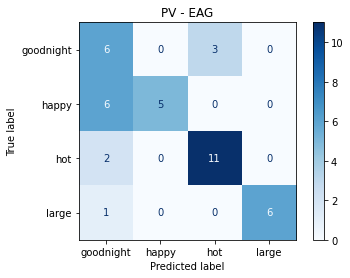

PCA inputs
    EMG0L    EMG0L     EMG0L     EMG0L     EMG0L  ...  OYR  OYR  OYR  OYR  OYR
69      0 -2.38658   1.86255   3.57951  -3.00842  ...   15   15   15   15   15
89      0        0         0         0  -1.19329  ...   83   83   83   83   83
83      0        0  -1.19329  0.632951 -0.587743  ...   65   64   63   62   60
22      0        0         0 -0.596644 -0.578491  ...  178  177  176  174  171
28      0        0  0.596644 -0.614797  0.302948  ...   39   38   36   35   33
..    ...      ...       ...       ...       ...  ...  ...  ...  ...  ...  ...
42      0  1.19329  -3.61617  0.678509    5.2215  ...   77   77   77   77   77
29      0        0   7.15973   -9.1675  0.109971  ...   76   76   76   76   76
18      0        0 -0.596644  -1.17514   1.54144  ...  170  166  164  161  159
16      0        0   2.98322   -1.8807  -2.69808  ...   84   83   84   84   84
116     0        0  -2.38658  -2.31396   4.30323  ...   47   48   48   49   50

[92 rows x 1400 columns]
    EMG0L EMG0L

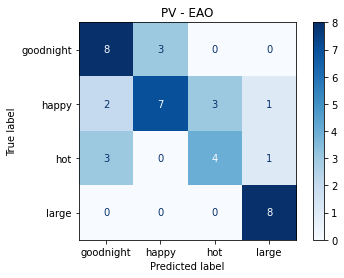

PCA inputs
    EMG0L    EMG0L     EMG0L      EMG0L     EMG0L  ...  OYR  OYR  OYR  OYR  OYR
76      0        0 -0.596644   0.614797 -0.302948  ...  123  122  122  122  122
111     0        0   1.19329   -6.00275  -8.19854  ...  158  159  159  159  159
42      0  1.19329  -3.61617   0.678509    5.2215  ...   77   77   77   77   77
117     0        0   3.57986    1.68101   1.65431  ...  111  112  113  114  117
86      0        0  -1.19329  0.0363065   1.22034  ...  156  157  157  157  157
..    ...      ...       ...        ...       ...  ...  ...  ...  ...  ...  ...
21      0        0 -0.596644  0.0181533 -0.284795  ...  166  162  160  158  156
63      0        0    5.3698    -10.903   8.25971  ...  173  173  172  172  172
5       0        0 -0.596644    5.98459   1.92025  ...   47   46   46   46   46
114     0        0  -2.38658   -1.71732   6.07501  ...   49   50   50   51   51
66      0        0  -1.19329  0.0363065   1.22034  ...  140  140  140  140  140

[92 rows x 1400 columns]
   

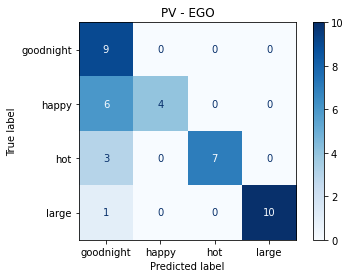

PCA inputs
           AXL        AXL       AXL       AXL  ...  OYR  OYR  OYR  OYR
61   -0.732422  -0.723633 -0.741211 -0.732422  ...   41   41   41   41
42    0.482422  -0.123047  -0.27832 -0.296875  ...   77   77   77   77
49   -0.297852  -0.295898 -0.294434 -0.296387  ...   65   65   65   65
93    0.724121   0.726562   0.74707  0.748047  ...  179  179  179  178
62    -0.59375  -0.611816 -0.655273 -0.584961  ...   40   38   37   36
..         ...        ...       ...       ...  ...  ...  ...  ...  ...
128  -0.765137  -0.810547 -0.360352 -0.121094  ...  172  173  173  174
55   -0.176758  -0.214355 -0.146484  0.161133  ...  106  105  103  101
69    0.543457   0.567383  0.495117  0.497559  ...   15   15   15   15
129 -0.0297852  0.0537109  0.208984   0.30957  ...  172  172  172  172
0    -0.652832  -0.593262  -0.49707 -0.245117  ...  118  117  117  117

[92 rows x 900 columns]
            AXL         AXL         AXL          AXL  ...  OYR  OYR  OYR  OYR
32     0.200195    0.237305    0.1

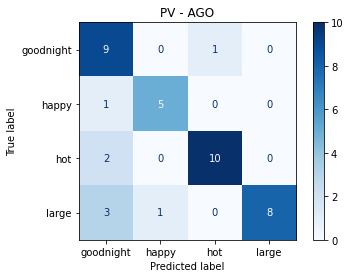

PCA inputs
    EMG0L EMG0L     EMG0L      EMG0L     EMG0L  ...  OYR  OYR  OYR  OYR  OYR
112     0     0  -9.54631    7.45018   11.9315  ...  156  156  156  156  156
117     0     0   3.57986    1.68101   1.65431  ...  111  112  113  114  117
94      0     0  -1.19329   -1.15698   1.85329  ...    1    1    0    0  179
97      0     0 -0.596644  0.0181533  0.908494  ...  173  172  172  172  173
60      0     0  -1.78993    1.84439   -0.3122  ...   41   41   40   39   38
..    ...   ...       ...        ...       ...  ...  ...  ...  ...  ...  ...
59      0     0         0   -1.78993   2.44104  ...   35   33   32   31   30
91      0     0 -0.596644   0.614797 -0.302948  ...   81   81   81   81   81
130     0     0  -7.15973    4.99099   12.5466  ...  164  165  166  168  169
54      0     0         0   -1.78993   2.44104  ...  171  169  167  165  164
61      0     0         0   -1.19329   1.22959  ...   41   41   41   41   41

[92 rows x 1700 columns]
    EMG0L EMG0L     EMG0L      EMG0L   

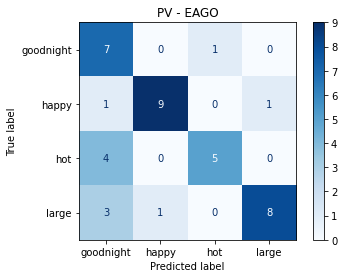

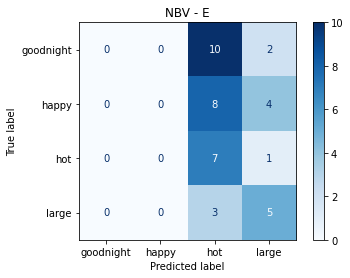

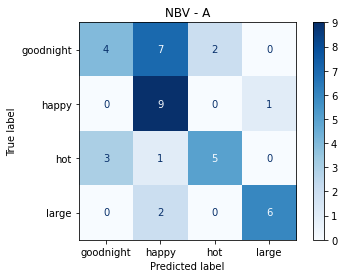

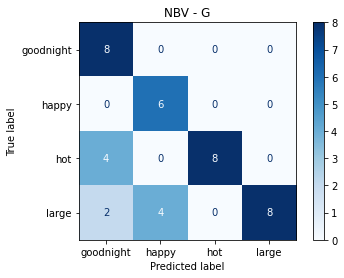

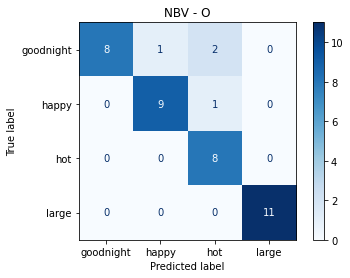

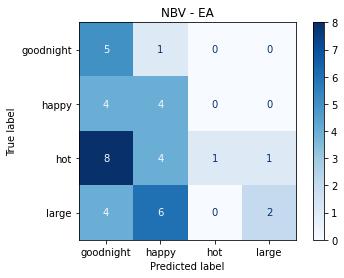

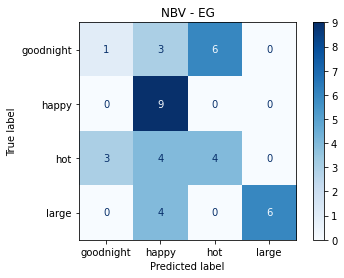

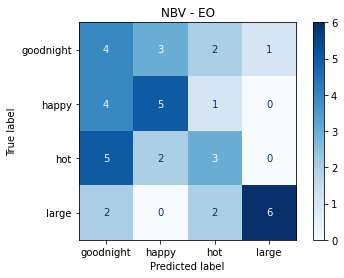

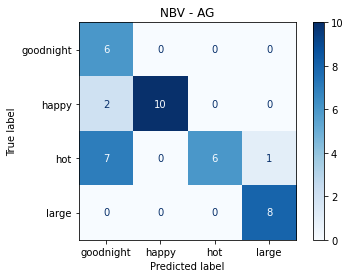

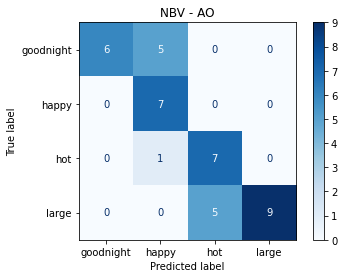

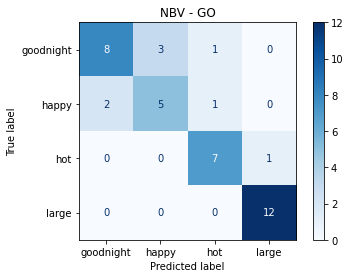

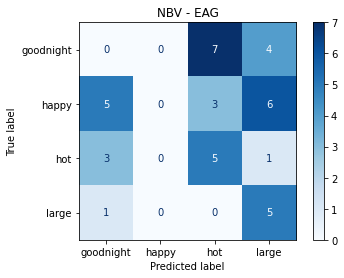

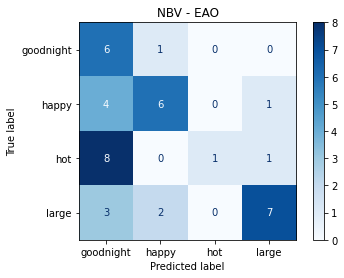

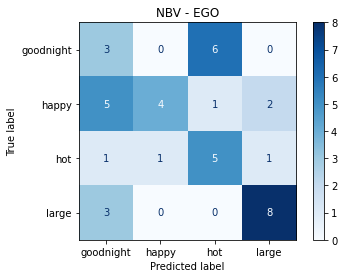

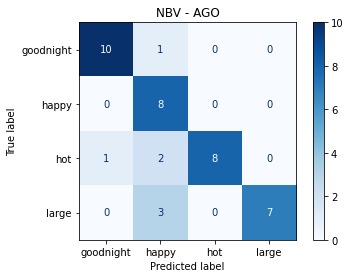

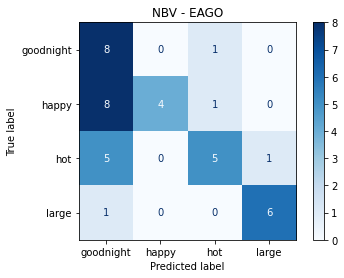

PCA inputs
        EMG0L       EMG0L     EMG0L  ...       EMG7R       EMG7R       EMG7R
47   0.317838 -0.00967043 -0.171701  ...   0.0346848  -0.0115969  -0.0354689
30   0.280057 -0.00852092 -0.152466  ... -0.00924941 -0.00354345  -0.0242955
22   0.332481  -0.0101159 -0.173779  ...  -0.0138944  -0.0103642  -0.0178663
63   0.313565  -0.0095404 -0.124696  ...   0.0243349   0.0696383   0.0658959
128  0.315272 -0.00959235 -0.127494  ...  0.00952899  -0.0092315 -0.00563287
..        ...         ...       ...  ...         ...         ...         ...
106    0.3016 -0.00917637 -0.223203  ...   0.0226151  -0.0506531   0.0631488
28   0.267653 -0.00814352 -0.134319  ...  -0.0676092  -0.0815138   -0.119552
24   0.358697  -0.0109136 -0.205238  ...  -0.0266179   0.0154515    -0.01729
38   0.298322 -0.00907663 -0.165321  ...  0.00606095  0.00650002  0.00949456
121  0.350476  -0.0106635 -0.183184  ...    0.177913  -0.0065531  -0.0476856

[92 rows x 800 columns]
        EMG0L       EMG0L      EMG0L  ..

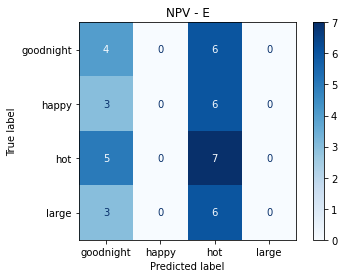

PCA inputs
           AXL         AXL        AXL  ...       AZR       AZR       AZR
116   0.300901    0.301962   0.288706  ...  0.844908  0.845704  0.846499
21    0.426616    0.453759   0.510449  ...  0.944751  0.941629   0.95484
108  0.0895035    0.108013       0.25  ...  0.663326  0.696427  0.708187
3            0  0.00484163   0.106996  ...  0.773663  0.775357  0.775841
81    0.307364    0.308965   0.302828  ...  0.859125  0.862593  0.860726
..         ...         ...        ...  ...       ...       ...       ...
47    0.344016     0.33082    0.35509  ...  0.574694   0.69345  0.991753
23    0.480071    0.526198   0.428962  ...  0.742526  0.749437  0.757955
95   0.0879352   0.0918796  0.0916473  ...   0.71044  0.709281  0.694431
90     0.36019     0.36019   0.373461  ...  0.749054  0.853082  0.867537
63           0    0.167355    0.23409  ...  0.823758  0.812809  0.768594

[92 rows x 300 columns]
           AXL       AXL         AXL  ...       AZR       AZR       AZR
122   0.517521  

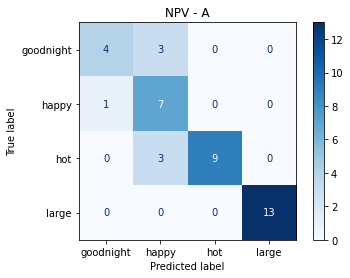

PCA inputs
          GXL       GXL       GXL  ...       GZR       GZR       GZR
56   0.523378  0.523094  0.469255  ...  0.797395         1   0.68518
98   0.404583  0.403511  0.403913  ...  0.225141  0.296704  0.312249
11   0.485069  0.426797  0.594996  ...   0.52494  0.520905  0.519775
35   0.505768  0.556594  0.915291  ...  0.476412  0.488973   0.52198
20   0.481735   0.46181  0.500489  ...  0.137527  0.190272  0.228756
..        ...       ...       ...  ...       ...       ...       ...
47   0.614029  0.614893  0.615757  ...  0.281789  0.517795  0.645128
91   0.437768  0.438286  0.438027  ...  0.433494   0.41847   0.43984
87   0.464054  0.460805  0.456691  ...  0.557817   0.60654  0.592681
105  0.555956  0.540563  0.544862  ...  0.794758  0.734711   0.59742
83   0.509473  0.510621  0.505645  ...  0.428707  0.441722   0.40421

[92 rows x 300 columns]
          GXL       GXL       GXL  ...        GZR        GZR        GZR
27   0.589233  0.589233  0.590879  ...   0.604709   0.592196   0

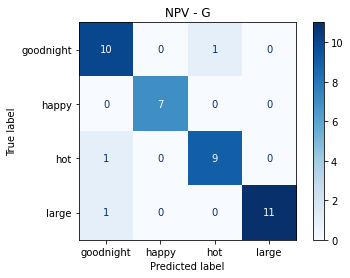

PCA inputs
          ORL       ORL       ORL  ...       OYR       OYR       OYR
51      0.112     0.112     0.112  ...     0.864     0.848      0.84
44   0.701754  0.701754  0.684211  ...  0.491228  0.491228  0.491228
48    0.53125   0.53125  0.515625  ...       0.5       0.5       0.5
20   0.346369  0.346369  0.351955  ...  0.871508  0.860335  0.854749
120  0.183333  0.191667  0.233333  ...     0.675  0.691667     0.725
..        ...       ...       ...  ...       ...       ...       ...
53   0.108527  0.108527  0.108527  ...  0.906977  0.891473  0.875969
81   0.553846  0.553846  0.553846  ...  0.507692  0.492308  0.492308
91     0.3375    0.3375    0.3375  ...    0.4125    0.4125    0.4125
14     0.5625    0.5625  0.578125  ...  0.546875  0.546875  0.546875
107  0.372727  0.372727  0.372727  ...  0.836364  0.845455  0.845455

[92 rows x 300 columns]
          ORL       ORL       ORL  ...        OYR        OYR        OYR
99   0.277778  0.277778  0.277778  ...   0.793651   0.785714   0

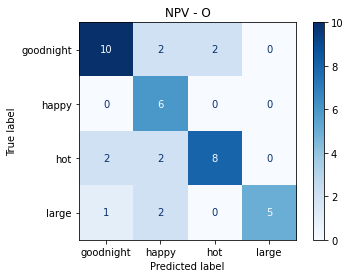

PCA inputs
        EMG0L       EMG0L     EMG0L  ...       AZR       AZR       AZR
53   0.359986  -0.0109528 -0.188155  ...  0.744817  0.762245  0.787561
27   0.378891   -0.011528 -0.211101  ...  0.907215  0.867959   0.85139
55   0.279404 -0.00850104 -0.143126  ...  0.716834  0.703515  0.676744
100  0.346886  -0.0105542 -0.148932  ...   0.79619  0.786558  0.787871
5    0.384415  -0.0116961 -0.204927  ...  0.859281  0.839014  0.840396
..        ...         ...       ...  ...       ...       ...       ...
82   0.272579 -0.00829337 -0.145498  ...  0.759371  0.790273  0.845261
74   0.332308  -0.0101107 -0.188793  ...  0.974733  0.955783  0.844825
35   0.319135 -0.00970988 -0.180679  ...  0.816723  0.773213  0.809188
110   0.29497 -0.00897464 -0.170932  ...    0.7187  0.761122  0.730026
45   0.270673 -0.00823538 -0.132742  ...  0.831487  0.843445  0.842795

[92 rows x 1100 columns]
        EMG0L       EMG0L      EMG0L  ...       AZR       AZR       AZR
112  0.302005 -0.00918868  -0.216778  .

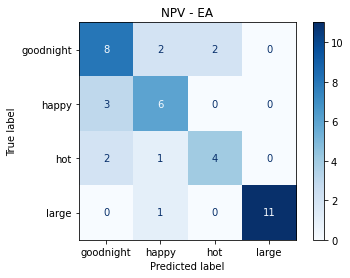

PCA inputs
        EMG0L       EMG0L      EMG0L  ...       GZR       GZR       GZR
46   0.265579 -0.00808041  -0.378924  ...  0.449563  0.453928  0.451018
122  0.279509 -0.00850423 -0.0923399  ...  0.404471  0.463188  0.460825
23   0.292473 -0.00889865  -0.138244  ...  0.420431  0.417622  0.418793
16   0.270673 -0.00823538  -0.126921  ...  0.488731  0.479717  0.471487
117   0.29404 -0.00894634  -0.136558  ...  0.697881  0.774181  0.840268
..        ...         ...        ...  ...       ...       ...       ...
49   0.260696 -0.00793183  -0.136259  ...  0.748202  0.769962  0.785116
95   0.325775  -0.0099119  -0.173934  ...  0.351506  0.358042  0.353578
94    0.18571 -0.00565035  -0.104968  ...  0.438234  0.401679  0.382771
100  0.346886  -0.0105542  -0.148932  ...  0.478087  0.463156   0.46205
11   0.324905 -0.00988544  -0.169819  ...   0.52494  0.520905  0.519775

[92 rows x 1100 columns]
        EMG0L       EMG0L      EMG0L  ...       GZR       GZR       GZR
76   0.302775  -0.0092121  

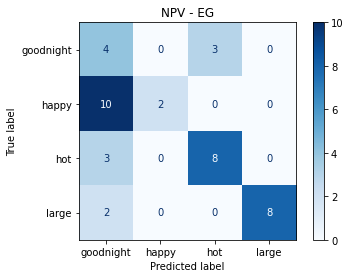

PCA inputs
        EMG0L       EMG0L      EMG0L  ...        OYR        OYR        OYR
85   0.317364 -0.00965599   -0.17434  ...   0.871508   0.865922   0.860335
10   0.188682 -0.00574077  -0.119017  ...   0.494382   0.494382   0.494382
36   0.295954 -0.00900459  -0.164158  ...  0.0512821  0.0512821  0.0512821
108  0.338481  -0.0102985  -0.205599  ...   0.820755   0.830189   0.830189
64   0.198881 -0.00605109 -0.0949097  ...   0.978102   0.978102   0.978102
..        ...         ...        ...  ...        ...        ...        ...
1    0.218084 -0.00663533  -0.130445  ...      0.625      0.625      0.625
33   0.359174  -0.0109281  -0.205541  ...   0.732673   0.722772   0.722772
16   0.270673 -0.00823538  -0.126921  ...   0.590909   0.590909   0.590909
44   0.329435  -0.0100233  -0.146564  ...   0.491228   0.491228   0.491228
13   0.384678  -0.0117041  -0.240314  ...   0.925926   0.925926   0.925926

[92 rows x 1100 columns]
        EMG0L       EMG0L      EMG0L  ...        OYR        OYR

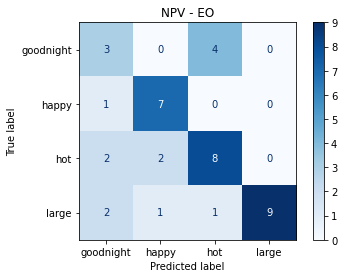

PCA inputs
          AXL       AXL       AXL  ...       GZR       GZR       GZR
16   0.233595  0.201627  0.205272  ...  0.488731  0.479717  0.471487
100  0.137697  0.152145  0.204903  ...  0.478087  0.463156   0.46205
8    0.347293  0.356077  0.378345  ...  0.463731  0.465899  0.466733
43   0.281885  0.405318  0.462387  ...    0.5263  0.529005  0.528855
107  0.165316  0.155076  0.109428  ...  0.609381  0.590939  0.584124
..        ...       ...       ...  ...       ...       ...       ...
54   0.458028  0.464444  0.474247  ...  0.207782  0.221701  0.221198
86   0.400262  0.401309  0.398691  ...   0.56325   0.49399  0.453248
119  0.461322  0.576058  0.547536  ...  0.807317  0.749729  0.714778
126  0.877972  0.842174  0.903057  ...  0.584635  0.569175  0.557858
109  0.501464   0.53095  0.592849  ...  0.622322  0.615051   0.61623

[92 rows x 600 columns]
           AXL         AXL        AXL  ...        GZR        GZR        GZR
103   0.478649    0.482192   0.485735  ...   0.710931   0.70

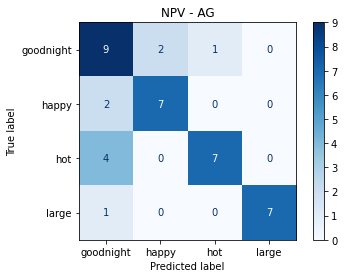

PCA inputs
           AXL        AXL        AXL  ...       OYR       OYR       OYR
65    0.327253   0.197187   0.373764  ...  0.985075  0.985075  0.985075
109   0.501464    0.53095   0.592849  ...  0.913295  0.907514  0.907514
19    0.414996   0.412847   0.522924  ...  0.865922  0.860335  0.854749
17    0.275328   0.275328   0.267153  ...  0.647059  0.647059  0.647059
94    0.813243   0.814303   0.806886  ...         0         0         1
..         ...        ...        ...  ...       ...       ...       ...
46           0   0.172437   0.430325  ...  0.378788  0.378788  0.378788
52    0.490321   0.543001   0.528854  ...  0.888889  0.880952  0.873016
131   0.289939   0.309734   0.426409  ...  0.964286  0.964286  0.964286
83    0.299805   0.301198   0.301476  ...  0.387097  0.370968   0.33871
75   0.0354796  0.0349543  0.0394217  ...  0.685039  0.685039  0.685039

[92 rows x 600 columns]
           AXL        AXL        AXL  ...        OYR        OYR        OYR
128   0.104852  0.0897103

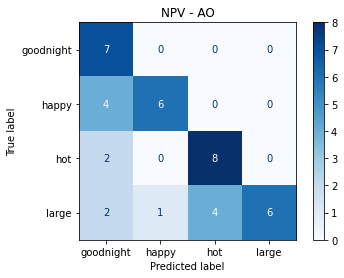

PCA inputs
          GXL       GXL       GXL  ...       OYR       OYR       OYR
124  0.491478  0.491478  0.270228  ...  0.505618  0.505618  0.505618
98   0.404583  0.403511  0.403913  ...   0.97191   0.97191   0.97191
90   0.446036  0.446036  0.436529  ...  0.415584  0.415584  0.415584
73   0.373228  0.372578  0.350332  ...  0.677966  0.677966  0.677966
93   0.555054  0.550968  0.541075  ...         1         1  0.994413
..        ...       ...       ...  ...       ...       ...       ...
101  0.540415  0.618163  0.408084  ...  0.740741  0.740741  0.740741
53   0.541249  0.467677  0.430891  ...  0.906977  0.891473  0.875969
96   0.381038  0.367087  0.367987  ...  0.977401  0.977401  0.971751
71   0.457828   0.45705  0.459695  ...  0.037594  0.037594  0.037594
127  0.539288  0.534958   0.62941  ...  0.955307  0.949721  0.944134

[92 rows x 600 columns]
          GXL        GXL       GXL  ...        OYR        OYR        OYR
112  0.757932   0.614877  0.564071  ...   0.884393   0.884393  

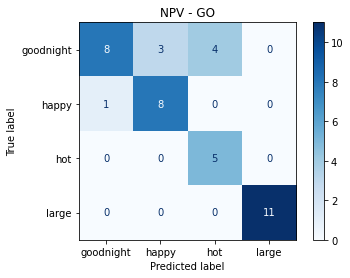

PCA inputs
        EMG0L       EMG0L     EMG0L  ...       GZR       GZR       GZR
27   0.378891   -0.011528 -0.211101  ...  0.604709  0.592196  0.574909
74   0.332308  -0.0101107 -0.188793  ...  0.243428   0.36303  0.382782
81   0.284116 -0.00864441 -0.152051  ...  0.520841  0.530265  0.511417
53   0.359986  -0.0109528 -0.188155  ...  0.252856  0.246784  0.231427
12   0.264458 -0.00804631 -0.131775  ...   0.63446   0.61476  0.632584
..        ...         ...       ...  ...       ...       ...       ...
72   0.314233 -0.00956071 -0.176174  ...  0.585301  0.571573  0.547632
131  0.177573 -0.00540275 -0.114121  ...  0.590271  0.569228   0.49756
62   0.312994 -0.00952302 -0.163593  ...  0.421149  0.404046  0.415229
70   0.293223 -0.00892147  -0.15071  ...   0.41846  0.431313  0.445167
95   0.325775  -0.0099119 -0.173934  ...  0.351506  0.358042  0.353578

[92 rows x 1400 columns]
        EMG0L       EMG0L      EMG0L  ...        GZR        GZR        GZR
112  0.302005 -0.00918868  -0.216778

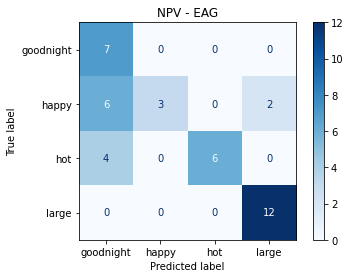

PCA inputs
        EMG0L       EMG0L      EMG0L  ...        OYR        OYR        OYR
1    0.218084 -0.00663533  -0.130445  ...      0.625      0.625      0.625
111  0.295534  -0.0089918  -0.148891  ...   0.918605   0.918605   0.918605
62   0.312994 -0.00952302  -0.163593  ...  0.0860215  0.0752688  0.0645161
7    0.254619 -0.00774693 -0.0152735  ...          0          0          0
108  0.338481  -0.0102985  -0.205599  ...   0.820755   0.830189   0.830189
..        ...         ...        ...  ...        ...        ...        ...
16   0.270673 -0.00823538  -0.126921  ...   0.590909   0.590909   0.590909
67   0.275049 -0.00836852  -0.147992  ...   0.779661   0.774011   0.774011
79   0.258123 -0.00785354  -0.109524  ...   0.380952   0.380952   0.380952
91   0.268189  -0.0081598  -0.143188  ...     0.4125     0.4125     0.4125
20   0.366613  -0.0111544  -0.191618  ...   0.871508   0.860335   0.854749

[92 rows x 1400 columns]
        EMG0L       EMG0L      EMG0L  ...        OYR        OYR

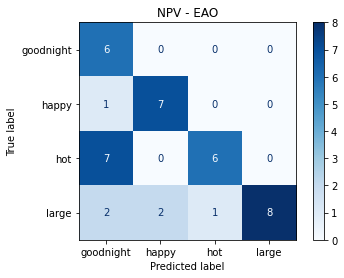

PCA inputs
        EMG0L       EMG0L      EMG0L  ...        OYR        OYR        OYR
88   0.372374  -0.0113297  -0.198861  ...   0.426667   0.426667   0.426667
64   0.198881 -0.00605109 -0.0949097  ...   0.978102   0.978102   0.978102
69   0.289599  -0.0227678  -0.140473  ...  0.0162602  0.0162602  0.0162602
70   0.293223 -0.00892147   -0.15071  ...  0.0252101  0.0168067  0.0168067
122  0.279509 -0.00850423 -0.0923399  ...   0.505882   0.505882   0.505882
..        ...         ...        ...  ...        ...        ...        ...
55   0.279404 -0.00850104  -0.143126  ...   0.958333   0.930556   0.902778
124  0.292234 -0.00889139  -0.122302  ...   0.505618   0.505618   0.505618
11   0.324905 -0.00988544  -0.169819  ...   0.521277   0.521277   0.510638
87   0.360933  -0.0109816  -0.196016  ...   0.865922   0.871508   0.871508
72   0.314233 -0.00956071  -0.176174  ...      0.016      0.016      0.016

[92 rows x 1400 columns]
        EMG0L       EMG0L      EMG0L  ...        OYR        OYR

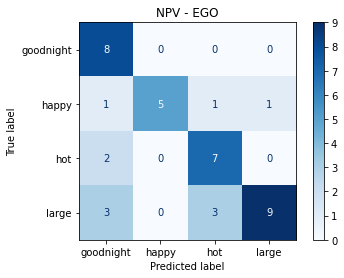

PCA inputs
          AXL        AXL       AXL  ...        OYR        OYR        OYR
129  0.467245   0.505219  0.575839  ...   0.966292   0.966292   0.966292
107  0.165316   0.155076  0.109428  ...   0.836364   0.845455   0.845455
104  0.636734   0.584012  0.616803  ...  0.0391061  0.0446927  0.0502793
70    0.60474   0.614704  0.610054  ...  0.0252101  0.0168067  0.0168067
53   0.506879   0.507062  0.505044  ...   0.906977   0.891473   0.875969
..        ...        ...       ...  ...        ...        ...        ...
124  0.409418   0.409418  0.335474  ...   0.505618   0.505618   0.505618
10          0  0.0478252  0.138909  ...   0.494382   0.494382   0.494382
25   0.359706   0.316642  0.367217  ...  0.0816327  0.0816327  0.0816327
83   0.299805   0.301198  0.301476  ...   0.387097   0.370968    0.33871
40    0.34868   0.341363         0  ...       0.72   0.733333   0.733333

[92 rows x 900 columns]
           AXL         AXL         AXL  ...        OYR        OYR        OYR
130  0.0879

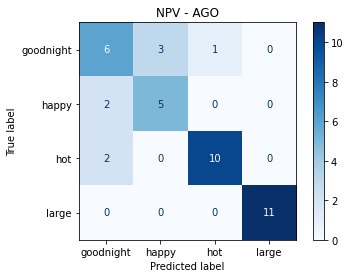

PCA inputs
        EMG0L       EMG0L      EMG0L  ...        OYR        OYR        OYR
7    0.254619 -0.00774693 -0.0152735  ...          0          0          0
71   0.252426 -0.00768022   -0.14341  ...   0.037594   0.037594   0.037594
124  0.292234 -0.00889139  -0.122302  ...   0.505618   0.505618   0.505618
6    0.279677 -0.00850934  -0.192792  ...  0.0582524  0.0582524  0.0582524
8    0.356062  -0.0108334   -0.17648  ...   0.474227   0.474227   0.474227
..        ...         ...        ...  ...        ...        ...        ...
56   0.336005  -0.0102231  -0.178761  ...   0.873418   0.962025          1
104  0.299492 -0.00911222  -0.184614  ...  0.0391061  0.0446927  0.0502793
74   0.332308  -0.0101107  -0.188793  ...      0.704      0.696      0.696
126  0.253122 -0.00770138   -0.15038  ...   0.960894   0.955307   0.955307
10   0.188682 -0.00574077  -0.119017  ...   0.494382   0.494382   0.494382

[92 rows x 1700 columns]
        EMG0L       EMG0L     EMG0L  ...        OYR        OYR 

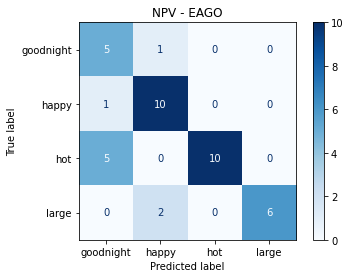

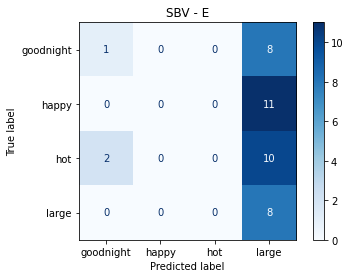

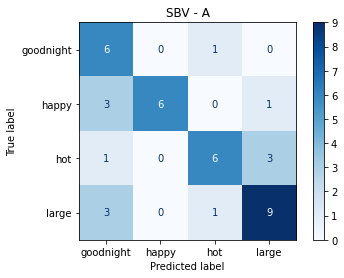

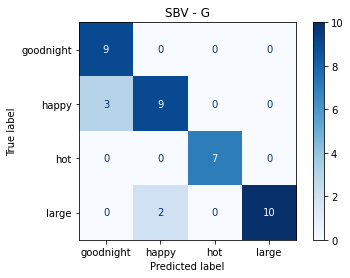

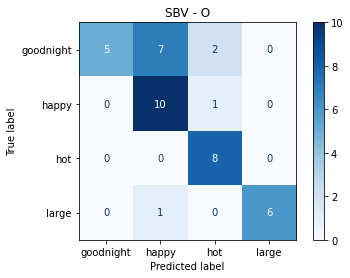

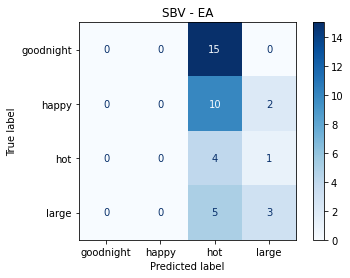

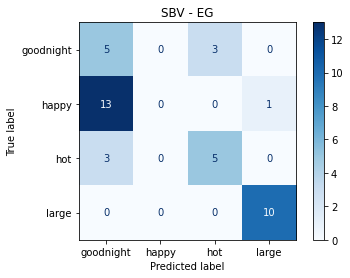

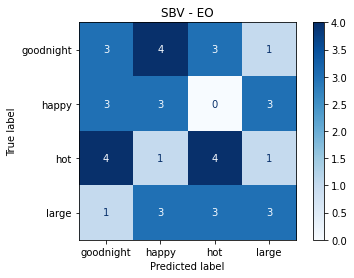

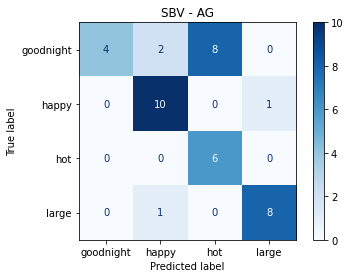

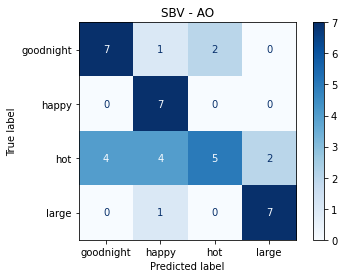

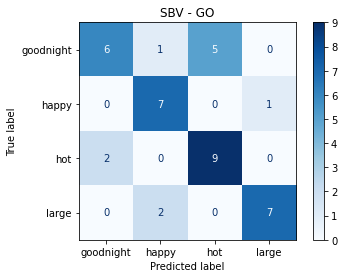

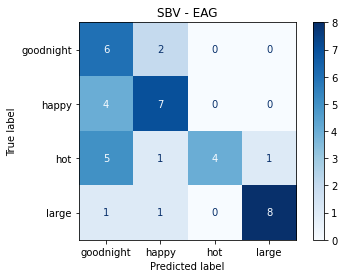

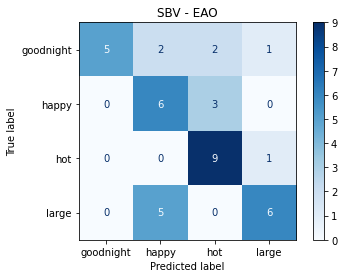

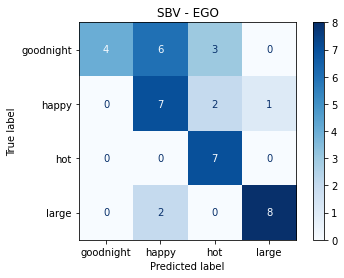

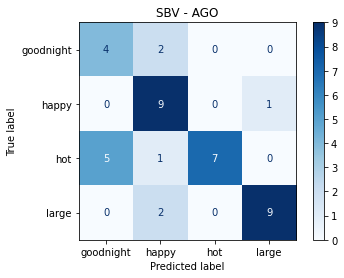

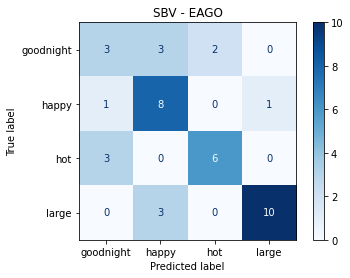

PCA inputs
        EMG0L        EMG0L       EMG0L  ...      EMG7R      EMG7R      EMG7R
80  0.0502059  -0.00152754   0.0682639  ...  -0.151839    1.09024   0.388434
22  0.0824407  -0.00250831  -0.0430895  ...  -0.215648  -0.160858  -0.277294
18  0.0610101  -0.00185627   -0.113919  ...   0.183205  -0.130459   0.116243
69  0.0446514    -0.170253    0.108471  ...   0.319474   0.105617   0.280194
26   0.060387  -0.00183731  0.00629757  ... -0.0137003  -0.165529  -0.049283
..        ...          ...         ...  ...        ...        ...        ...
6   0.0297936 -0.000906489   -0.571164  ...  -0.118149  -0.133955   0.069645
45  0.0694256  -0.00211231    0.083671  ...  -0.989868  -0.199011 -0.0199219
34  0.0451872  -0.00137485   -0.462039  ...  -0.716852  0.0954646  -0.298045
0   0.0704893  -0.00214468   -0.105529  ...   0.033786   0.127916 -0.0158556
61  0.0676496  -0.00205828  -0.0353586  ...   0.102632   0.219457   0.526416

[92 rows x 800 columns]
           EMG0L        EMG0L       EMG0

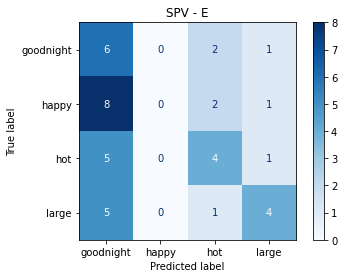

PCA inputs
          AXL       AXL        AXL  ...       AZR       AZR       AZR
53  -0.265531 -0.264645  -0.274389  ...  0.883429  0.967587   1.08984
30  -0.407171 -0.429516  -0.684774  ...   1.30486    1.2679    1.2911
1   -0.997611 -0.322069  -0.575757  ...   1.01556  0.995382  0.977123
102  0.508162  0.856429   0.287729  ...  0.445064   1.42923   1.79717
116  -0.67361  -0.67012  -0.713755  ...   1.11719    1.1198   1.12242
..        ...       ...        ...  ...       ...       ...       ...
50  -0.387217 -0.508827  -0.495407  ...   1.49816   1.44867   1.35558
126    1.1465   1.02463    1.23189  ...   1.08334  0.913436   0.86896
125  0.771829  0.700575 -0.0611615  ...   1.01443   1.02037  0.972866
29   -1.20628  -1.26022   -0.71004  ...   1.28986   1.29567   1.30148
81  -0.495465 -0.490452  -0.509669  ...   1.23227   1.24313   1.23728

[92 rows x 300 columns]
           AXL         AXL        AXL  ...       AZR       AZR       AZR
0     -1.82037    -1.70522   -1.51928  ...   1.0338

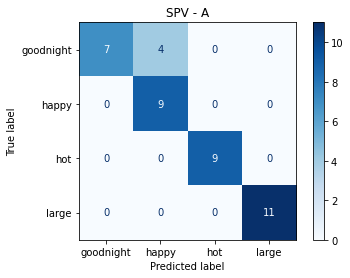

PCA inputs
           GXL        GXL        GXL  ...        GZR        GZR        GZR
28  -0.0271449 -0.0869192  -0.354274  ...  -0.462954  -0.511861    -0.5086
20    0.485289   0.355673    0.60728  ...   -1.75376   -1.41066   -1.16032
12    0.384117   0.949441   0.457306  ...   0.192311  0.0333138   0.177168
74  -0.0386131 -0.0343621 -0.0928129  ...   -1.18744   -0.25435  -0.100252
106   0.827612    1.18969    1.00905  ...  0.0215695  0.0954299  0.0496686
..         ...        ...        ...  ...        ...        ...        ...
131   0.985225    1.02237    1.70965  ...   0.407253   0.308662 -0.0271194
44   0.0308689  -0.308345   -0.21419  ... -0.0310408 -0.0168532 -0.0220123
29     1.65113    1.89429    2.05903  ... -0.0801897 -0.0857927 -0.0768279
124 -0.0722838 -0.0722838   -1.32956  ... -0.0469813 -0.0530888 -0.0391288
120    1.05106    0.99171     1.6497  ...    1.84925    1.72132    1.47881

[92 rows x 300 columns]
             GXL         GXL        GXL  ...         GZR        

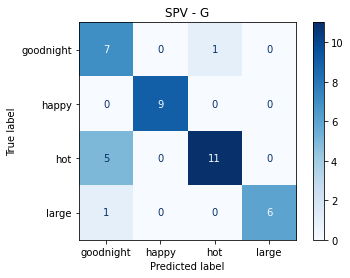

PCA inputs
         ORL       ORL        ORL  ...        OYR        OYR        OYR
48  0.089441  0.089441  0.0287344  ... -0.0319721 -0.0319721 -0.0319721
18  -0.84185  -0.84185   -0.84185  ...    2.03814    1.95259    1.89556
22 -0.786832 -0.786832  -0.786832  ...    2.37789    2.32237    2.23909
78  0.449524  0.449524   0.449524  ...   -2.34965   -2.34965   -2.34965
89 -0.522054 -0.522054  -0.522054  ...  -0.119557  -0.119557  -0.119557
..       ...       ...        ...  ...        ...        ...        ...
94  0.279836  0.279836   0.279836  ...   -1.80304   -1.80304    2.12154
19 -0.831169 -0.831169  -0.831169  ...    1.77302    1.74471     1.7164
61 -0.206048 -0.206048  -0.206048  ...   -1.45159   -1.45159   -1.45159
84  -1.03927  -1.03927   -1.03927  ...     1.6052    1.57549    1.51606
21 -0.814542 -0.786729  -0.786729  ...    1.91111    1.85548    1.79985

[92 rows x 300 columns]
           ORL        ORL        ORL  ...       OYR        OYR       OYR
32   -0.577093  -0.577093  

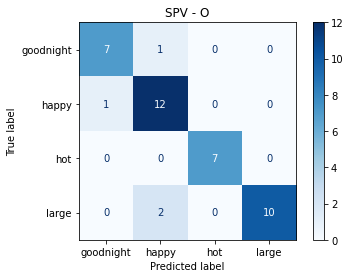

PCA inputs
         EMG0L        EMG0L       EMG0L  ...       AZR       AZR       AZR
51   0.0672849  -0.00204718   -0.035168  ...   1.20344    1.1567   1.24047
54  0.00612356 -0.000186313 -0.00320061  ...  0.855627  0.967804    1.0765
4   0.00419773 -0.000127719   -0.444061  ...    1.2282   1.25892   1.23117
72   0.0697413  -0.00212192   -0.199908  ...   1.13304   1.32176   1.37649
46    0.058362   -0.0017757    -2.61784  ...   1.31547   1.30807   1.28581
..         ...          ...         ...  ...       ...       ...       ...
33   0.0480378  -0.00146158   -0.279052  ...  0.951655  0.901709  0.964605
97   0.0396762  -0.00120717  -0.0895901  ...   1.30239   1.15476   1.30493
38   0.0156398  -0.00047585  -0.0964413  ...   1.08289   1.08806   1.11078
90   0.0617351  -0.00187833  -0.0798932  ...  0.683569   1.06818   1.12162
37  -0.0182734   0.00055598    0.225805  ...  0.821395  0.784978  0.787119

[92 rows x 1100 columns]
         EMG0L        EMG0L      EMG0L  ...       AZR       AZR

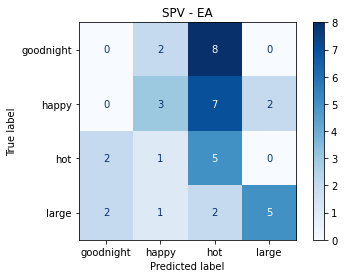

PCA inputs
         EMG0L        EMG0L      EMG0L  ...         GZR         GZR        GZR
126  0.0442954  -0.00134771  -0.224114  ...    0.401314     0.30911   0.241621
78   0.0736083  -0.00223958    0.41757  ...   0.0166535   0.0373138  -0.107308
128  0.0392444  -0.00119403   0.557965  ...   -0.392562 -0.00381583 -0.0904425
95   0.0792379  -0.00241086   -0.12417  ...    -0.08494  -0.0347835 -0.0690367
93   0.0334716  -0.00101839 -0.0174947  ...  0.00376636   -0.362045  -0.525775
..         ...          ...        ...  ...         ...         ...        ...
21   0.0847651  -0.00257903  -0.129389  ...    -2.09691    -1.89109   -1.64926
127  0.0124037 -0.000377389  0.0547696  ...  -0.0303069  -0.0842201  -0.123692
18   0.0610101  -0.00185627  -0.113919  ...    -2.56853    -2.30205   -2.33631
22   0.0824407  -0.00250831 -0.0430895  ...    -1.70367    -2.11723    -2.6287
99     0.09937  -0.00302339  -0.739223  ...   0.0179319   -0.190511  -0.248165

[92 rows x 1100 columns]
          EMG0L

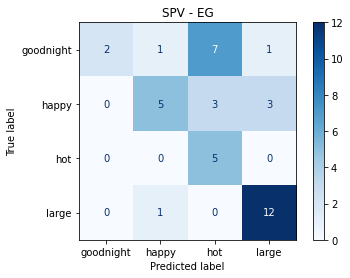

PCA inputs
         EMG0L        EMG0L      EMG0L  ...       OYR       OYR       OYR
24    0.106909  -0.00325278  -0.273064  ...  -1.54282  -1.54282  -1.54282
97   0.0396762  -0.00120717 -0.0895901  ...   2.00857   2.00857   2.03338
117  0.0197413 -0.000600642   0.210564  ...  0.548612  0.579147  0.670752
56   0.0534306  -0.00162566 -0.0640589  ...   1.05354   1.38272    1.5238
58   0.0169569 -0.000515925  0.0650638  ...    1.5497    1.5497   1.45922
..         ...          ...        ...  ...       ...       ...       ...
53   0.0736189   -0.0022399 -0.0384786  ...   1.97546   1.91933    1.8632
38   0.0156398  -0.00047585 -0.0964413  ...  -1.85773  -1.85773  -1.82608
109  0.0366823  -0.00111608    2.11076  ...   1.64563   1.61903   1.61903
114  0.0272842 -0.000830139  -0.260898  ...  -1.30895  -1.23315  -1.23315
87   0.0235986    -0.000718  -0.131821  ...   1.63399   1.66275   1.66275

[92 rows x 1100 columns]
          EMG0L        EMG0L       EMG0L  ...       OYR        OYR       OY

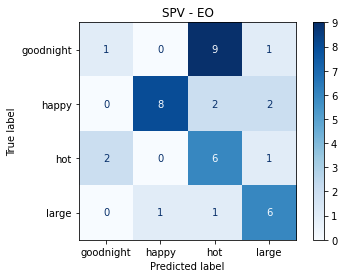

PCA inputs
          AXL       AXL        AXL  ...        GZR         GZR         GZR
86  -0.417929 -0.414447  -0.423152  ...   0.802475     0.26416  -0.0524964
103  0.343857  0.359631   0.375407  ...    1.89795     1.86487     1.13558
118  -0.11358 -0.149508  0.0950052  ...    2.11772     1.91742      1.8284
20  -0.462108 -0.447946  -0.208964  ...   -1.75376    -1.41066    -1.16032
45   0.471031  0.175567  -0.694616  ... -0.0632431  -0.0528838  -0.0497761
..        ...       ...        ...  ...        ...         ...         ...
31    -1.4345  -1.49986   -1.44808  ... -0.0662576   -0.112851  -0.0481379
47  -0.507835 -0.554213  -0.468912  ...   -1.96897   -0.469511    0.339486
125  0.771829  0.700575 -0.0611615  ...   0.697121    0.440087    0.339957
1   -0.997611 -0.322069  -0.575757  ...  0.0162146   0.0132539  0.00239817
16  -0.651049 -0.761469  -0.748877  ...  0.0658746 -0.00090495  -0.0618776

[92 rows x 600 columns]
           AXL       AXL        AXL  ...         GZR         GZR

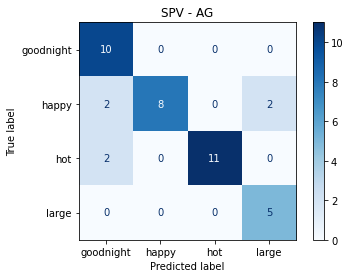

PCA inputs
          AXL       AXL        AXL  ...       OYR       OYR       OYR
0    -1.82037  -1.70522   -1.51928  ...  0.918442  0.918442  0.918442
107  -1.58131  -1.62752    -1.8335  ...   1.25442   1.28988   1.28988
118  -0.11358 -0.149508  0.0950052  ...   0.94634   1.06828   1.15973
130  -1.96682  -1.99288   -1.28823  ...   1.93674   1.99201   2.01965
131  -1.22236  -1.14231  -0.670497  ...    2.1187    2.1187    2.1187
..        ...       ...        ...  ...       ...       ...       ...
35   -1.79295  -1.75521   -2.08358  ...   1.39445   1.35818   1.32191
63    -2.1525  -1.43258    -1.1455  ...   2.03416   2.03416   2.03416
71   0.433135  0.492878   0.473913  ...  -1.91271  -1.91271  -1.91271
65  -0.677497  -1.40471  -0.417445  ...   2.04065   2.04065   2.04065
42    0.37092 -0.769438   -1.06188  ... -0.402561 -0.402561 -0.402561

[92 rows x 600 columns]
          AXL       AXL        AXL  ...       OYR       OYR       OYR
8   -0.829874 -0.790173  -0.689535  ... -0.730929 -0.7

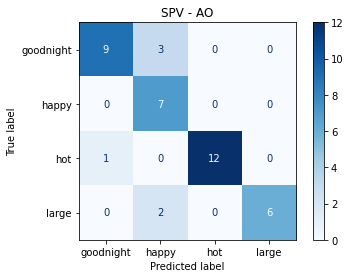

PCA inputs
           GXL       GXL         GXL  ...       OYR       OYR       OYR
86  -0.0936617 -0.125327   -0.126911  ...   1.69979   1.69979   1.69979
38    0.872834 -0.486338    0.869658  ...  -1.85773  -1.85773  -1.82608
111   0.156477 -0.433711 -0.00420753  ...   1.71286   1.71286   1.71286
57    0.626337  -2.47737     1.42223  ...   1.36774   1.41307   1.41307
20    0.485289  0.355673     0.60728  ...   1.77617   1.71982   1.69165
..         ...       ...         ...  ...       ...       ...       ...
13    -2.04456  -2.06808    0.387397  ...   1.88635   1.88635   1.88635
5     -2.39603  -2.39603    -1.34036  ...  -1.65037  -1.65037  -1.65037
115  -0.627099  -1.62856    -1.01583  ...  -1.02524  -1.09391  -1.09391
131   0.985225   1.02237     1.70965  ...    2.1187    2.1187    2.1187
17    0.831632  0.831632    0.594709  ...  0.347844  0.347844  0.347844

[92 rows x 600 columns]
             GXL          GXL        GXL  ...       OYR        OYR       OYR
18      -0.06091   -0.0

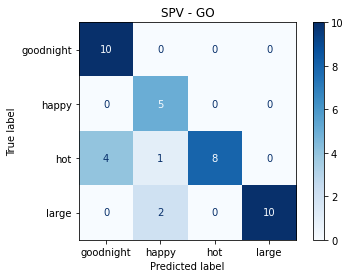

PCA inputs
           EMG0L        EMG0L      EMG0L  ...        GZR        GZR        GZR
95     0.0792379  -0.00241086   -0.12417  ...   -0.08494 -0.0347835 -0.0690367
83    0.00928407 -0.000282473 -0.0720675  ...   -0.81508   -0.69225   -1.04629
61     0.0676496  -0.00205828 -0.0353586  ...  -0.377415  -0.162205  -0.231008
106     0.115251  -0.00350657  -0.810445  ...  0.0215695  0.0954299  0.0496686
56     0.0534306  -0.00162566 -0.0640589  ...    1.76727    2.96944    1.10144
..           ...          ...        ...  ...        ...        ...        ...
60   0.000652685 -1.98583e-05  -0.120837  ...  -0.486176   -0.37483  -0.324364
58     0.0169569 -0.000515925  0.0650638  ...    0.71436   0.246838  -0.675241
11      0.124809  -0.00379738  -0.065234  ... -0.0900397  -0.119186  -0.127347
67      0.100768  -0.00306591  -0.121569  ...  -0.667272  -0.446694  -0.140466
108    0.0992365  -0.00301933  -0.445273  ...   0.237328 -0.0235001  -0.100214

[92 rows x 1400 columns]
         EMG0L 

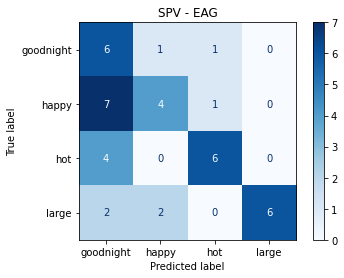

PCA inputs
          EMG0L        EMG0L      EMG0L  ...       OYR       OYR       OYR
36    0.0417021  -0.00126881  -0.123046  ...  -1.92214  -1.92214  -1.92214
70    0.0556481  -0.00169313  0.0169996  ...  -1.93481  -1.96662  -1.96662
25    0.0114015 -0.000346897  -0.292274  ...  -1.36394  -1.36394  -1.36394
119 -0.00495857  0.000150867     0.3394  ...    1.0905   1.18008    1.2398
51    0.0672849  -0.00204718  -0.035168  ...   1.80664   1.74835    1.7192
..          ...          ...        ...  ...       ...       ...       ...
64    0.0201093 -0.000611836   0.103991  ...   1.96629   1.96629   1.96629
66    0.0470523   -0.0014316  -0.172498  ...   1.27895   1.27895   1.27895
79    0.0430739  -0.00131055   0.275834  ...   -1.7109   -1.7109   -1.7109
84     0.044028  -0.00133958 -0.0718643  ...    1.6052   1.57549   1.51606
124   0.0268709 -0.000817564   0.297502  ...  0.113696  0.113696  0.113696

[92 rows x 1400 columns]
           EMG0L        EMG0L      EMG0L  ...       OYR       O

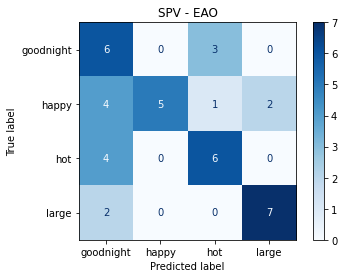

PCA inputs
         EMG0L        EMG0L      EMG0L  ...       OYR       OYR       OYR
122  0.0647247  -0.00196929   0.623274  ...   0.14676   0.14676   0.14676
87   0.0235986    -0.000718  -0.131821  ...   1.63399   1.66275   1.66275
73    0.108847  -0.00331175   -0.14836  ...  0.543318  0.543318  0.543318
51   0.0672849  -0.00204718  -0.035168  ...   1.80664   1.74835    1.7192
53   0.0736189   -0.0022399 -0.0384786  ...   1.97546   1.91933    1.8632
..         ...          ...        ...  ...       ...       ...       ...
115  0.0492009  -0.00149697   0.145915  ...  -1.02524  -1.09391  -1.09391
62    0.025718 -0.000782486 -0.0134421  ...  -1.76244    -1.804  -1.84556
67    0.100768  -0.00306591  -0.121569  ...   1.14744   1.11782   1.11782
93   0.0334716  -0.00101839 -0.0174947  ...   1.94132   1.94132   1.91985
96   0.0843766  -0.00256721    0.15983  ...   1.95426   1.95426   1.92922

[92 rows x 1400 columns]
          EMG0L        EMG0L      EMG0L  ...       OYR       OYR       OYR


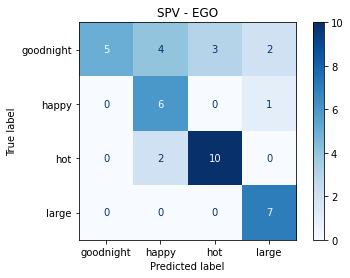

PCA inputs
          AXL       AXL        AXL  ...        OYR        OYR        OYR
48   -0.61941 -0.616025  -0.781907  ... -0.0319721 -0.0319721 -0.0319721
0    -1.82037  -1.70522   -1.51928  ...   0.918442   0.918442   0.918442
9    -1.21057 -0.987838  -0.834419  ...  -0.698743  -0.698743  -0.698743
94   0.839235  0.844154   0.809715  ...   -1.80304   -1.80304    2.12154
29   -1.20628  -1.26022   -0.71004  ...  -0.941342  -0.941342  -0.941342
..        ...       ...        ...  ...        ...        ...        ...
62   -1.37356  -1.40543   -1.48208  ...   -1.76244     -1.804   -1.84556
129  -0.48694 -0.334788 -0.0518391  ...    2.12686    2.12686    2.12686
71   0.433135  0.492878   0.473913  ...   -1.91271   -1.91271   -1.91271
98    -1.1152  -1.11773   -1.14475  ...    1.99172    1.99172    1.99172
41   -1.73749  -1.76031   -1.98023  ...   0.495261   0.495261   0.495261

[92 rows x 900 columns]
          AXL       AXL        AXL  ...       OYR        OYR       OYR
64   0.885556  0.

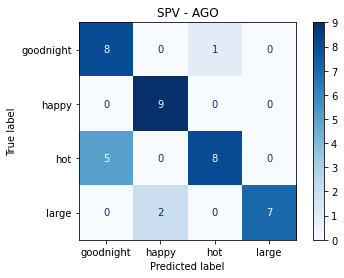

PCA inputs
         EMG0L        EMG0L      EMG0L  ...       OYR       OYR       OYR
98   0.0784642  -0.00238732  -0.267214  ...   1.99172   1.99172   1.99172
37  -0.0182734   0.00055598   0.225805  ...  -1.97271  -1.97271  -1.97271
93   0.0334716  -0.00101839 -0.0174947  ...   1.94132   1.94132   1.91985
32    0.107316  -0.00326516  -0.328857  ... -0.401328 -0.401328 -0.401328
51   0.0672849  -0.00204718  -0.035168  ...   1.80664   1.74835    1.7192
..         ...          ...        ...  ...       ...       ...       ...
106   0.115251  -0.00350657  -0.810445  ...   1.03812   1.03812   1.07137
110  0.0341041  -0.00103764   -0.22867  ...   1.71385   1.71385   1.71385
127  0.0124037 -0.000377389  0.0547696  ...   2.03727   2.00964     1.982
95   0.0792379  -0.00241086   -0.12417  ...   1.92137   1.92137   1.92137
74   0.0882901  -0.00268628    -0.2335  ...  0.696832  0.659943  0.659943

[92 rows x 1700 columns]
         EMG0L        EMG0L       EMG0L  ...        OYR        OYR        O

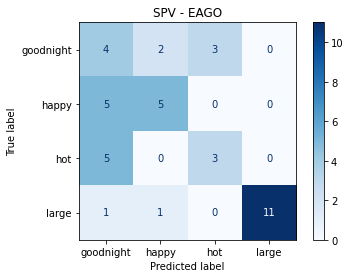

PCA inputs
    EMG0L EMG0L     EMG0L      EMG0L  ...    EMG7R    EMG7R     EMG7R     EMG7R
71      0     0  -1.06795    1.13294  ... -2.32136 -2.42932  -2.76671  -2.88447
44      0     0   2.49189   -7.27132  ...  4.45194  1.29779  -1.72522  -7.73068
126     0     0  -1.06795    2.20089  ...  10.8694 -16.8195  -3.83988   1.62076
109     0     0   16.0193   -16.9941  ...  7.74143 -3.08143 -0.317694   8.95215
56      0     0 -0.355984  0.0216621  ...  3.83035 -12.3765  -8.87087  0.387277
..    ...   ...       ...        ...  ...      ...      ...       ...       ...
87      0     0 -0.711968    1.11128  ... -5.35299 -3.70463  -1.78722 -0.669113
21      0     0 -0.355984   0.377646  ... -2.44617 -2.56778  -1.08127 -0.959815
120     0     0 -0.711968    3.24718  ...  1.39162  4.84437   4.59209  -2.81317
122     0     0   3.55984   -8.40426  ...  2.13854  1.05179 -0.288474   3.63359
105     0     0  -10.3235    24.8351  ... -3.14401 -11.6482   -21.893  -8.36894

[92 rows x 800 columns]
    

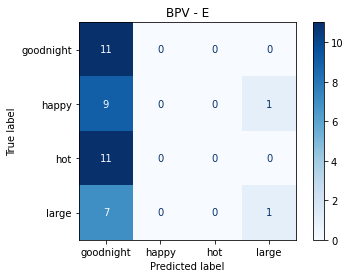

PCA inputs
            AXL        AXL         AXL  ...       AZR       AZR       AZR
79  -0.00976562  0.0117188 -0.00292969  ...   1.01318   1.01318   1.01807
59    -0.763184  -0.830078   -0.852051  ...  0.932617  0.898438  0.861328
39     0.670898   0.590332    0.597168  ...  0.884766  0.900391  0.898926
66    -0.552734  -0.534668   -0.541992  ...  0.859375  0.865234  0.866699
53    0.0771484  0.0776367   0.0722656  ...  0.710449  0.756836  0.824219
..          ...        ...         ...  ...       ...       ...       ...
62     -0.59375  -0.611816   -0.655273  ...   1.01807   1.03271   1.04199
50    -0.097168  -0.167969   -0.160156  ...   1.00049   0.97168   0.91748
6     -0.112793  0.0405273    0.043457  ...  0.973145  0.936523   0.94043
63    -0.922363  -0.526855   -0.369141  ...   1.02441  0.998535  0.894043
114   -0.178711  -0.184082  -0.0107422  ...  0.905273  0.974609  0.965332

[92 rows x 300 columns]
            AXL         AXL         AXL  ...       AZR       AZR       AZR
1

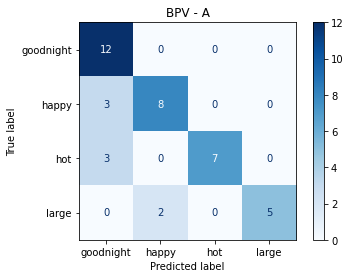

PCA inputs
         GXL      GXL      GXL      GXL  ...      GZR      GZR      GZR      GZR
94   -2.3125     -2.5  -0.4375     1.25  ...   -9.625 -16.6875 -27.5625 -33.1875
80  -14.5625    -5.75  -1.0625   -5.375  ...  -0.4375      0.5     0.25    -0.25
9    67.0625  89.0625  89.5625  83.4375  ...   0.6875  -1.0625  -1.4375    0.875
110   -20.25   -2.875 -21.4375  29.6875  ...  -3.1875   -3.625       -1       -2
38    52.875  -27.375  52.6875 -46.1875  ...    9.875    3.375   3.8125  10.3125
..       ...      ...      ...      ...  ...      ...      ...      ...      ...
48     -0.75     -0.5      -31   1.4375  ...       11    2.125    9.875  11.3125
30   47.6875  49.4375  26.4375   6.9375  ...  -0.1875   0.3125  -3.1875   -2.125
93    2.1875        1   -1.875  -1.8125  ...   2.6875   0.3125 -15.1875  -22.125
59  -86.3125   -59.75    -75.5 -59.0625  ...      -55  -45.375      -36 -33.3125
47      3.25   3.5625    3.875     0.75  ... -144.562 -116.938 -31.5625     14.5

[92 rows x 300 c

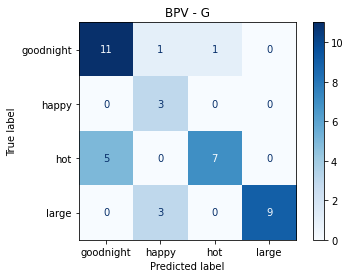

PCA inputs
    ORL ORL ORL  ORL  ORL  ORL  ORL  ...  OYR  OYR  OYR  OYR  OYR  OYR  OYR
65   71  73  75   78   80   82   85  ...  174  174  174  174  174  174  174
64   84  85  85   84   82   80   79  ...  172  172  172  172  172  172  172
8    96  97  99  100  100  101  101  ...   82   82   82   82   82   82   82
39   87  87  84   83   82   81   83  ...   13   13   12   11   10   10    9
112  84  84  82   82   83   84   84  ...  156  156  156  156  156  156  156
..   ..  ..  ..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
76   76  76  76   76   76   76   76  ...  125  124  123  122  122  122  122
110  84  84  83   83   85   85   85  ...  159  159  160  160  160  160  160
40   83  84  84   85   86   85   85  ...   95   96   97   98   99  100  100
106  77  78  82   84   88   90   92  ...  117  118  120  120  121  121  122
83   73  73  73   73   73   73   73  ...   66   66   65   64   63   62   60

[92 rows x 300 columns]
     ORL ORL ORL ORL ORL ORL ORL ORL  ...  OYR  OYR 

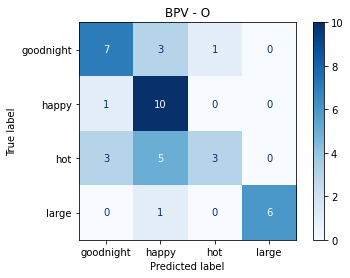

PCA inputs
    EMG0L EMG0L     EMG0L     EMG0L  ...       AZR       AZR       AZR       AZR
30      0     0 -0.355984   1.08961  ...   0.87793  0.888184  0.867188  0.880371
1       0     0  -1.42394   3.64649  ...  0.834961  0.816895  0.806641  0.797363
79      0     0   2.13591  -3.33383  ...   1.02148   1.01318   1.01318   1.01807
83      0     0 -0.711968   1.11128  ...  0.824219  0.850098  0.844238  0.891602
32      0     0  -1.42394 -0.269336  ...   0.89502  0.916016  0.884277     0.875
..    ...   ...       ...       ...  ...       ...       ...       ...       ...
109     0     0   16.0193  -16.9941  ...  0.708008  0.702637  0.708496  0.708984
117     0     0   2.13591  -1.19793  ...  0.793457  0.768555  0.786133  0.884277
4       0     0  -3.55984   1.64056  ...  0.959473  0.948242  0.963379  0.949707
29      0     0   4.27181  -9.87152  ...  0.875977  0.876465  0.879883  0.883301
100     0     0   2.49189  -7.98329  ...  0.870605  0.804688  0.783203  0.786133

[92 rows x 1100 

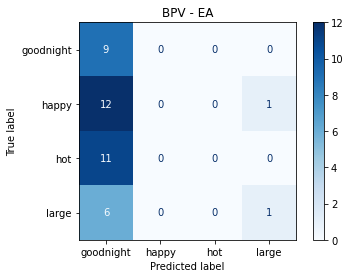

PCA inputs
    EMG0L EMG0L     EMG0L     EMG0L  ...      GZR      GZR      GZR     GZR
127     0     0  0.355984  -2.51355  ...   36.375     6.25     2.75  0.1875
47      0     0 -0.711968  0.755293  ... -144.562 -116.938 -31.5625    14.5
106     0     0  -3.55984   10.8961  ...     15.5    1.125    6.875  3.3125
8       0     0  0.355984  -2.51355  ...    -0.75     -0.5   0.3125   0.625
46      0     0   -23.495   52.6914  ...   1.1875        0   1.6875  0.5625
..    ...   ...       ...       ...  ...      ...      ...      ...     ...
28      0     0  0.355984 -0.733631  ... -23.0625  -24.625 -27.4375  -27.25
62      0     0         0         0  ...  -61.375  -38.125  -44.625 -40.375
107     0     0  -10.3235   23.0552  ...  -5.5625  27.1875  18.5625  15.375
103     0     0  -3.55984   8.40426  ...  211.125  157.125  154.375   93.75
58      0     0  0.711968  -3.95915  ...  52.3125    51.75  17.9375  -48.75

[92 rows x 1100 columns]
    EMG0L     EMG0L     EMG0L      EMG0L  ...      

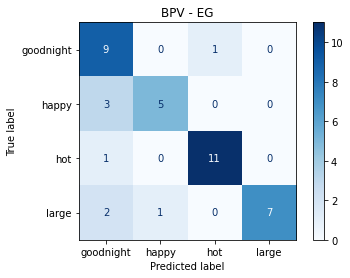

PCA inputs
    EMG0L EMG0L     EMG0L      EMG0L     EMG0L  ...  OYR  OYR  OYR  OYR  OYR
95      0     0 -0.355984   0.377646  0.350135  ...  173  173  173  173  173
15      0     0  -1.42394    3.29051  -1.55565  ...   83   83   83   83   83
81      0     0 -0.355984     1.4456  -2.56273  ...   71   70   70   69   69
11      0     0         0          0  0.355984  ...   85   85   85   85   84
10      0     0  -1.42394    2.22255    1.7132  ...   85   85   85   85   85
..    ...   ...       ...        ...       ...  ...  ...  ...  ...  ...  ...
75      0     0  0.355984    -1.4456   1.13879  ...  120  120  120  120  120
35      0     0  -1.42394     5.7824  -10.2509  ...  135  135  133  132  131
121     0     0         0    1.77992  -5.09209  ...   77   77   77   77   76
106     0     0  -3.55984    10.8961  -12.5952  ...  120  120  121  121  122
88      0     0 -0.355984  0.0216621  0.727781  ...   84   84   84   84   84

[92 rows x 1100 columns]
    EMG0L     EMG0L     EMG0L      EMG0

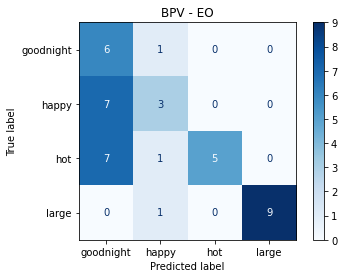

PCA inputs
           AXL        AXL        AXL  ...      GZR      GZR      GZR
11   -0.601074  -0.635742  -0.498047  ...  -4.1875    -5.75  -6.1875
131   -0.34082  -0.299316 -0.0546875  ...  38.4375  29.8125   0.4375
5    0.0898438  0.0898438 -0.0546875  ...  -3.1875     3.25    2.375
72    0.551758   0.541992   0.549316  ...      5.5    0.375  -8.5625
70    0.519531   0.541504    0.53125  ...  -9.3125     -4.5   0.6875
..         ...        ...        ...  ...      ...      ...      ...
128  -0.765137  -0.810547  -0.360352  ...  -29.125   4.8125    -2.75
125   0.699219   0.658203   0.219727  ...  39.4375   23.875  17.8125
103   0.334961   0.344238   0.353516  ...  157.125  154.375    93.75
121   -0.18457  -0.270996  0.0786133  ...   -14.75  -2.4375  -3.6875
63   -0.922363  -0.526855  -0.369141  ...   -32.25      7.5  17.0625

[92 rows x 600 columns]
            AXL         AXL         AXL  ...      GZR      GZR      GZR
59    -0.763184   -0.830078   -0.852051  ...  -45.375      -36 -

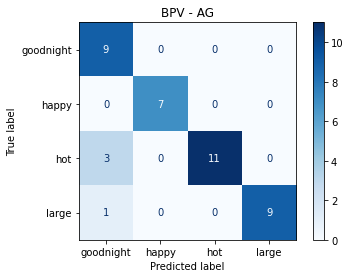

PCA inputs
            AXL        AXL         AXL        AXL  ...  OYR  OYR  OYR  OYR
47    -0.158203  -0.185547   -0.135254  -0.113281  ...   78   74   71   68
79  -0.00976562  0.0117188 -0.00292969 -0.0166016  ...   70   70   70   70
46    -0.891602  -0.507324   0.0673828   0.422363  ...   68   68   68   68
99    -0.461426   -0.45459   -0.445801  -0.459961  ...  143  144  143  143
122    0.090332    0.15332    0.257324   0.293457  ...   79   78   78   78
..          ...        ...         ...        ...  ...  ...  ...  ...  ...
86   -0.0595703 -0.0576172     -0.0625  -0.065918  ...  157  157  157  157
73    -0.502441   -0.50293   -0.486328  -0.498047  ...  114  114  114  114
124   -0.206055  -0.206055   -0.391602  -0.206543  ...   79   79   79   79
7     0.0791016  0.0927734   0.0854492  0.0615234  ...   45   45   45   45
42     0.482422  -0.123047    -0.27832  -0.296875  ...   77   77   77   77

[92 rows x 600 columns]
            AXL         AXL         AXL          AXL  ...  OYR  

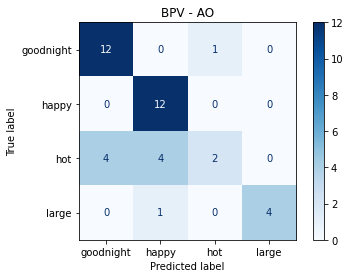

PCA inputs
         GXL      GXL      GXL      GXL      GXL  ...  OYR  OYR  OYR  OYR  OYR
106   63.875  92.0625       78   93.125  84.5625  ...  120  120  121  121  122
102  57.6875  -26.875  -31.875   8.6875    -1.75  ...  147  154  165  171  179
43    -3.375  -27.875 -58.9375  -26.125  -12.875  ...   77   77   77   77   77
18   -0.3125   -0.125   -0.375  -1.9375    2.125  ...  170  166  164  161  159
131       89    92.25  152.375  170.625      167  ...  169  169  170  170  170
..       ...      ...      ...      ...      ...  ...  ...  ...  ...  ...  ...
32   27.5625  31.1875  15.9375    9.125    7.125  ...   83   83   83   83   83
79   -1.9375   2.3125  -5.4375    -0.75  -6.6875  ...   70   70   70   70   70
6   -27.1875   -19.75   -123.5 -84.6875 -93.6875  ...   48   48   48   48   48
72    -1.125    -0.25   0.3125    1.375  -0.4375  ...   11   12   12   12   12
81   -1.4375    -1.75  -0.3125     0.75    0.375  ...   71   70   70   69   69

[92 rows x 600 columns]
         GXL    

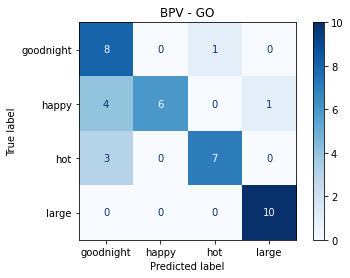

PCA inputs
    EMG0L EMG0L     EMG0L    EMG0L  ...      GZR      GZR      GZR      GZR
33      0     0  -2.13591 -4.85381  ... -16.8125  -14.125   -13.25    -13.5
2       0     0 -0.711968  1.11128  ...        0        0  -0.3125  -0.4375
80      0     0  0.711968  1.02463  ...  -0.4375      0.5     0.25    -0.25
16      0     0   1.77992 -2.95618  ...  -1.1875    5.125     2.25   -0.375
40      0     0  -1.42394  2.22255  ...   8.5625    21.25  11.3125   6.3125
..    ...   ...       ...      ...  ...      ...      ...      ...      ...
130     0     0  -4.27181  7.37963  ...      -31 -40.8125  -36.625 -18.8125
127     0     0  0.355984 -2.51355  ...   36.375     6.25     2.75   0.1875
103     0     0  -3.55984  8.40426  ...  211.125  157.125  154.375    93.75
119     0     0   3.20386 -7.67063  ...  92.9375  96.0625  76.1875   64.125
6       0     0  -3.55984  1.64056  ...  -2.6875   1.1875    1.125  -0.4375

[92 rows x 1400 columns]
    EMG0L     EMG0L     EMG0L     EMG0L  ...      G

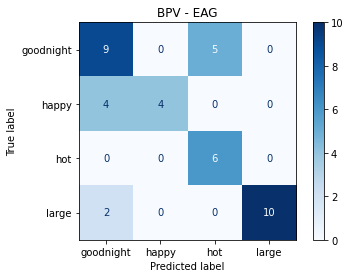

PCA inputs
    EMG0L EMG0L     EMG0L      EMG0L     EMG0L  ...  OYR  OYR  OYR  OYR  OYR
83      0     0 -0.711968    1.11128 -0.389346  ...   65   64   63   62   60
94      0     0 -0.711968  0.0433241   2.16753  ...    1    1    0    0  179
40      0     0  -1.42394    2.22255   2.06918  ...   97   98   99  100  100
85      0     0 -0.711968   0.755293   1.41224  ...  156  156  156  155  154
11      0     0         0          0  0.355984  ...   85   85   85   85   84
..    ...   ...       ...        ...       ...  ...  ...  ...  ...  ...  ...
16      0     0   1.77992   -2.95618   -1.3297  ...   84   83   84   84   84
117     0     0   2.13591   -1.19793  -1.09784  ...  111  112  113  114  117
34      0     0  -3.91583    9.49387   6.01844  ...  131  130  129  129  128
106     0     0  -3.55984    10.8961  -12.5952  ...  120  120  121  121  122
71      0     0  -1.06795    1.13294   2.83032  ...   15   14   14   14   14

[92 rows x 1400 columns]
    EMG0L     EMG0L     EMG0L      EMG0

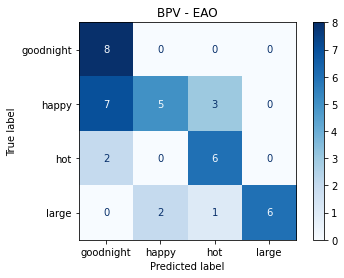

PCA inputs
   EMG0L EMG0L     EMG0L      EMG0L     EMG0L  ...  OYR  OYR  OYR  OYR  OYR
61     0     0         0  -0.711968   1.46726  ...   41   41   41   41   41
79     0     0   2.13591   -3.33383  -5.23968  ...   70   70   70   70   70
86     0     0 -0.711968   0.755293   1.05625  ...  156  157  157  157  157
8      0     0  0.355984   -2.51355    5.1196  ...   82   82   82   82   82
97     0     0 -0.355984   0.377646  0.706119  ...  173  172  172  172  173
..   ...   ...       ...        ...       ...  ...  ...  ...  ...  ...  ...
89     0     0         0          0 -0.711968  ...   83   83   83   83   83
32     0     0  -1.42394  -0.269336   4.71271  ...   83   83   83   83   83
88     0     0 -0.355984  0.0216621  0.727781  ...   84   84   84   84   84
62     0     0         0          0  -1.06795  ...   40   40   38   37   36
0      0     0 -0.355984   0.377646    1.0621  ...  118  118  117  117  117

[92 rows x 1400 columns]
    EMG0L EMG0L     EMG0L      EMG0L      EMG0L  ..

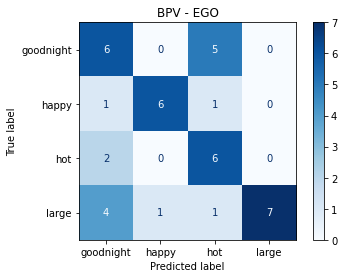

PCA inputs
           AXL        AXL        AXL        AXL  ...  OYR  OYR  OYR  OYR
108  -0.545898  -0.504395  -0.186035  -0.125488  ...  124  125  126  126
19   -0.078125 -0.0825195   0.142578   0.110352  ...  157  155  154  153
65   -0.216797  -0.672852 -0.0537109   0.337402  ...  174  174  174  174
112  -0.245117  -0.236328   0.153809   0.305664  ...  156  156  156  156
20  -0.0424805  -0.034668   0.097168  0.0830078  ...  158  156  154  153
..         ...        ...        ...        ...  ...  ...  ...  ...  ...
124  -0.206055  -0.206055  -0.391602  -0.206543  ...   79   79   79   79
16  -0.0224609  -0.078125 -0.0717773 -0.0268555  ...   83   84   84   84
23  -0.0507812  0.0893555  -0.206055  -0.257324  ...   35   35   35   35
93    0.724121   0.726562    0.74707   0.748047  ...  179  179  179  178
81   -0.208008  -0.205078  -0.216309  -0.195801  ...   70   70   69   69

[92 rows x 900 columns]
            AXL         AXL         AXL        AXL  ...  OYR  OYR  OYR  OYR
102    0.369

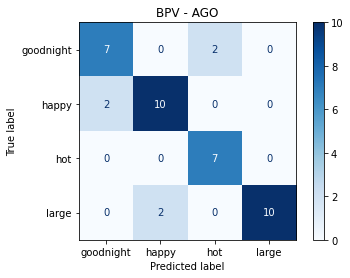

PCA inputs
    EMG0L EMG0L     EMG0L      EMG0L      EMG0L  ...  OYR  OYR  OYR  OYR  OYR
119     0     0   3.20386   -7.67063    3.16047  ...  123  125  130  133  135
105     0     0  -10.3235    24.8351   -2.79438  ...  169  174    0    4    6
26      0     0  0.355984   -1.08961    1.11713  ...   38   39   39   39   39
95      0     0 -0.355984   0.377646   0.350135  ...  173  173  173  173  173
48      0     0         0  -0.355984  0.0216621  ...   69   69   69   69   69
..    ...   ...       ...        ...        ...  ...  ...  ...  ...  ...  ...
30      0     0 -0.355984    1.08961    0.30681  ...   80   80   80   80   80
56      0     0 -0.355984  0.0216621   0.371797  ...   96   99  102  109  112
96      0     0   1.06795   -2.55688  -0.251787  ...  173  173  173  173  172
11      0     0         0          0   0.355984  ...   85   85   85   85   84
118     0     0  0.355984   -2.15757    1.18211  ...  118  122  125  129  132

[92 rows x 1700 columns]
    EMG0L EMG0L     EMG0L  

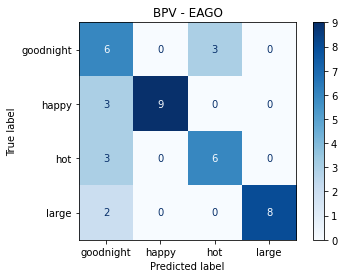

PCA inputs
        EMG0L     EMG0L     EMG0L  ...       EMG7R       EMG7R        EMG7R
96   0.159057 -0.168736 -0.148869  ...  -0.0252045  -0.0158248 -0.000800468
86   0.214056 -0.227081 -0.215192  ...  -0.0495537  -0.0532561   -0.0455217
13   0.229516 -0.243482 -0.249165  ...    0.210241   -0.137214     0.102382
26   0.171454 -0.181887 -0.167183  ...  -0.0145734  -0.0111154   0.00516863
3    0.177992 -0.188823  -0.18166  ...   -0.011946  -0.0129759  -0.00401077
..        ...       ...       ...  ...         ...         ...          ...
78   0.210227 -0.223019 -0.184348  ...    0.015786  -0.0323081    0.0899116
74    0.19827 -0.210335 -0.204024  ...  -0.0299337  -0.0187487    0.0408169
42   0.190128 -0.197652 -0.203431  ...   -0.052164   0.0397674    0.0482076
122  0.166767 -0.176915 -0.131956  ...  0.00947558 -0.00259887    0.0327351
44   0.196556 -0.208516 -0.178038  ...  0.00796189  -0.0105842   -0.0474275

[92 rows x 800 columns]
        EMG0L     EMG0L      EMG0L  ...        EMG7R

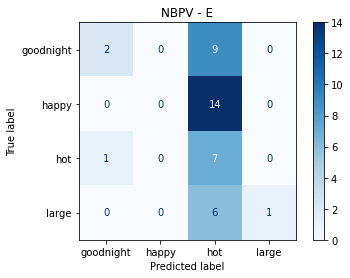

PCA inputs
            AXL        AXL        AXL  ...       AZR       AZR       AZR
33     0.126699          0   0.254737  ...  0.745264  0.734929  0.747943
128    0.104852  0.0897103   0.239824  ...  0.805113  0.864702  0.512374
102    0.636031   0.732952   0.574685  ...  0.618471  0.892359  0.994755
114    0.360693   0.357889   0.448381  ...  0.926586  0.962783   0.95794
48     0.291146   0.292187   0.241146  ...  0.860676  0.859635  0.868228
..          ...        ...        ...  ...       ...       ...       ...
95    0.0879352  0.0918796  0.0916473  ...   0.71044  0.709281  0.694431
13     0.404505    0.43422   0.410736  ...  0.747184  0.748862  0.745028
50     0.353651    0.31196   0.316561  ...         1  0.983035   0.95112
2    0.00569141  0.0044543  0.0586484  ...  0.778766  0.780251   0.77926
34     0.308269   0.340827   0.413695  ...  0.724031  0.717829  0.730749

[92 rows x 300 columns]
           AXL        AXL         AXL  ...       AZR       AZR       AZR
92    0.351146 

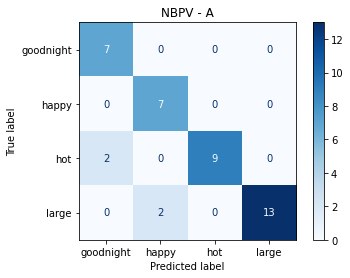

PCA inputs
          GXL        GXL       GXL  ...       GZR       GZR       GZR
10   0.829798   0.930847  0.831135  ...  0.581279  0.578223  0.580133
80   0.558146   0.574997  0.583961  ...  0.586949  0.586471  0.585515
103  0.403588   0.425074  0.435817  ...  0.710931  0.706058  0.598626
121  0.503633   0.754358  0.649417  ...  0.450726  0.479359  0.476452
104  0.618732   0.577223  0.528974  ...  0.610809  0.565397  0.546358
..        ...        ...       ...  ...       ...       ...       ...
117  0.503083    0.50501  0.571869  ...  0.697881  0.774181  0.840268
57   0.636224  0.0174582  0.794896  ...         1  0.682655  0.725058
131  0.713632   0.721561  0.868253  ...  0.590271  0.569228   0.49756
67   0.455222   0.463662   0.46867  ...  0.377253  0.404149  0.441488
26   0.440954   0.437748  0.371958  ...  0.443055  0.442724  0.443166

[92 rows x 300 columns]
          GXL       GXL       GXL  ...       GZR       GZR       GZR
37   0.645964  0.503339  0.339952  ...  0.473731  0.485

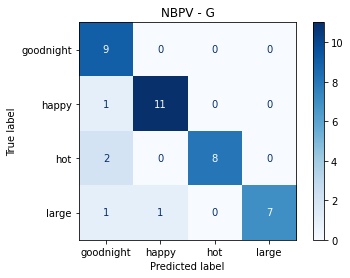

PCA inputs
          ORL       ORL       ORL  ...        OYR        OYR        OYR
58   0.414634  0.414634  0.390244  ...          1          1    0.97561
65   0.216418  0.231343  0.246269  ...   0.985075   0.985075   0.985075
70   0.571429  0.571429  0.571429  ...  0.0252101  0.0168067  0.0168067
4    0.530612  0.530612  0.510204  ...  0.0306122  0.0306122  0.0306122
96   0.384181  0.384181  0.384181  ...   0.977401   0.977401   0.971751
..        ...       ...       ...  ...        ...        ...        ...
83   0.548387  0.548387  0.548387  ...   0.387097   0.370968    0.33871
112  0.468208  0.468208  0.456647  ...   0.884393   0.884393   0.884393
124  0.426966  0.426966  0.404494  ...   0.505618   0.505618   0.505618
3    0.352381  0.342857   0.32381  ...   0.628571   0.628571   0.628571
73   0.355932  0.355932  0.355932  ...   0.677966   0.677966   0.677966

[92 rows x 300 columns]
           ORL        ORL        ORL  ...        OYR        OYR         OYR
81    0.553846   0.55384

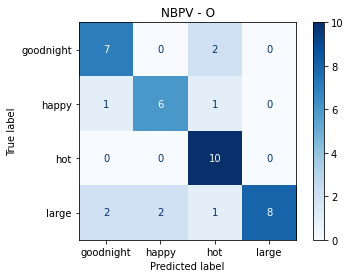

PCA inputs
       EMG0L     EMG0L     EMG0L  ...       AZR       AZR       AZR
24  0.214014 -0.227037 -0.221092  ...  0.750859  0.747968  0.740922
38  0.177992 -0.188823 -0.180673  ...  0.809937  0.811077  0.816091
52  0.171057 -0.181466 -0.169788  ...  0.796166  0.812361  0.811244
66  0.137459 -0.145824  -0.14225  ...  0.840471  0.843233  0.843924
4   0.166348  -0.17647 -0.180249  ...  0.792578  0.799507  0.793249
..       ...       ...       ...  ...       ...       ...       ...
91  0.160013  -0.16975 -0.159182  ...  0.715002  0.803657  0.867018
90  0.214934 -0.228013 -0.213081  ...  0.749054  0.853082  0.867537
8   0.212442  -0.22537  -0.20321  ...    0.7953  0.796526  0.794074
2   0.158215 -0.167843 -0.160269  ...  0.778766  0.780251   0.77926
28  0.159694 -0.169411 -0.153743  ...  0.842057  0.841353  0.833139

[92 rows x 1100 columns]
        EMG0L     EMG0L     EMG0L  ...       AZR       AZR       AZR
129  0.187503 -0.198913  -0.15453  ...  0.832335  0.824118  0.838997
55   0.16

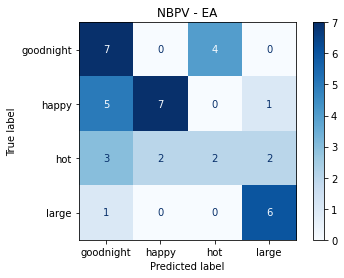

PCA inputs
        EMG0L     EMG0L     EMG0L  ...       GZR       GZR       GZR
62   0.186746  -0.19811 -0.183677  ...  0.421149  0.404046  0.415229
61   0.176176 -0.186896 -0.173281  ...  0.574631  0.613538  0.601099
16   0.161495 -0.171322 -0.150159  ...  0.488731  0.479717  0.471487
78   0.210227 -0.223019 -0.184348  ...  0.449691  0.452302  0.434029
46   0.158456 -0.168099 -0.299115  ...  0.449563  0.453928  0.451018
..        ...       ...       ...  ...       ...       ...       ...
111  0.176329 -0.187058 -0.170104  ...   0.60134  0.594813  0.599399
125  0.146765 -0.155696 -0.141231  ...   0.60901   0.56807  0.552121
117  0.175437 -0.186113 -0.162335  ...  0.697881  0.774181  0.840268
108  0.201953 -0.214242 -0.215749  ...  0.535652  0.492013  0.479177
90   0.214934 -0.228013 -0.213081  ...  0.420327  0.419523  0.434387

[92 rows x 1100 columns]
        EMG0L     EMG0L      EMG0L  ...       GZR       GZR       GZR
124   0.17436  -0.18497  -0.153332  ...  0.495931  0.494856  0.49

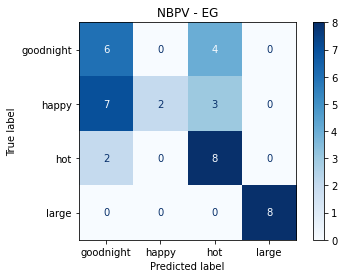

PCA inputs
        EMG0L     EMG0L     EMG0L  ...        OYR        OYR        OYR
41   0.183036 -0.194174 -0.184352  ...       0.75       0.75       0.75
43   0.154154 -0.163534 -0.175459  ...   0.532258   0.532258   0.532258
128  0.188105 -0.199552 -0.162765  ...    0.96648    0.96648   0.972067
117  0.175437 -0.186113 -0.162335  ...   0.541667       0.55      0.575
70    0.17495 -0.185595 -0.170553  ...  0.0252101  0.0168067  0.0168067
..        ...       ...       ...  ...        ...        ...        ...
121   0.20911 -0.221834 -0.205673  ...   0.533333   0.533333   0.522222
123  0.159006 -0.168682  -0.16114  ...   0.546392   0.546392   0.546392
92   0.146818 -0.155752 -0.144406  ...        0.4        0.4        0.4
95   0.194372   -0.2062 -0.193362  ...   0.966292   0.966292   0.966292
4    0.166348  -0.17647 -0.180249  ...  0.0306122  0.0306122  0.0306122

[92 rows x 1100 columns]
        EMG0L     EMG0L     EMG0L  ...        OYR        OYR        OYR
72   0.187485 -0.198894 -0.

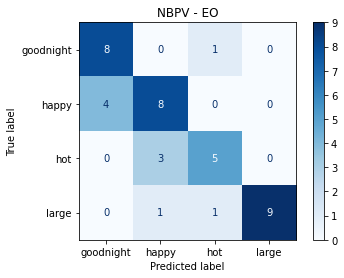

PCA inputs
          AXL       AXL        AXL  ...       GZR       GZR       GZR
101  0.100437  0.110263    0.28035  ...   0.48386  0.488912  0.491006
83   0.299805  0.301198   0.301476  ...  0.428707  0.441722   0.40421
69   0.581255  0.590883   0.561801  ...  0.435679  0.437907  0.437907
52   0.490321  0.543001   0.528854  ...  0.250608  0.283386  0.287694
119  0.461322  0.576058   0.547536  ...  0.807317  0.749729  0.714778
..        ...       ...        ...  ...       ...       ...       ...
46          0  0.172437   0.430325  ...  0.449563  0.453928  0.451018
112  0.310032  0.313658   0.474617  ...  0.622333  0.628576  0.624761
78   0.318702   0.31684   0.322958  ...  0.449691  0.452302  0.434029
96   0.093274  0.100465  0.0856599  ...  0.376688  0.357336  0.362586
17   0.275328  0.275328   0.267153  ...  0.439695  0.439528  0.437366

[92 rows x 600 columns]
            AXL         AXL        AXL  ...       GZR       GZR       GZR
90      0.36019     0.36019   0.373461  ...  0.420

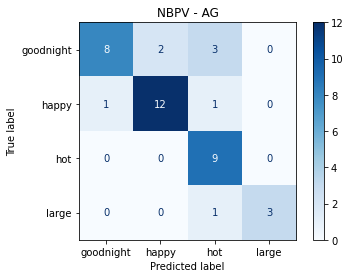

PCA inputs
           AXL         AXL        AXL  ...        OYR        OYR        OYR
76    0.164395    0.159984   0.168605  ...   0.708661   0.708661   0.708661
114   0.360693    0.357889   0.448381  ...   0.206349   0.222222   0.222222
3            0  0.00484163   0.106996  ...   0.628571   0.628571   0.628571
87    0.389432    0.392009   0.394844  ...   0.865922   0.871508   0.871508
89    0.315091    0.311569   0.316175  ...   0.428571   0.428571   0.428571
..         ...         ...        ...  ...        ...        ...        ...
130  0.0879118   0.0814082   0.257232  ...   0.907143   0.921429   0.928571
1      0.23648    0.403226   0.340608  ...      0.625      0.625      0.625
25    0.359706    0.316642   0.367217  ...  0.0816327  0.0816327  0.0816327
31    0.057524   0.0377503  0.0534154  ...   0.407407   0.407407   0.407407
55    0.427543    0.417288   0.435801  ...   0.958333   0.930556   0.902778

[92 rows x 600 columns]
           AXL        AXL        AXL  ...        OYR

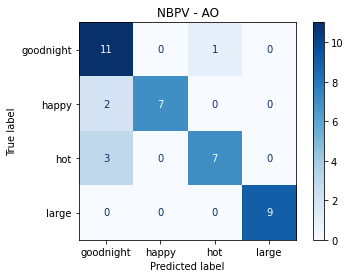

PCA inputs
         GXL       GXL       GXL  ...        OYR        OYR        OYR
26  0.440954  0.437748  0.371958  ...  0.0952381  0.0952381  0.0952381
99  0.423081  0.430564  0.418769  ...   0.793651   0.785714   0.785714
74  0.390683  0.391228  0.383736  ...      0.704      0.696      0.696
8   0.696348  0.670001  0.595464  ...   0.474227   0.474227   0.474227
53  0.541249  0.467677  0.430891  ...   0.906977   0.891473   0.875969
..       ...       ...       ...  ...        ...        ...        ...
34  0.637643  0.621525  0.703067  ...   0.745098   0.745098   0.735294
68  0.441616   0.43416  0.443164  ...   0.632812   0.632812   0.632812
14  0.545391   0.50512  0.465543  ...   0.546875   0.546875   0.546875
62  0.379708  0.295347  0.236803  ...  0.0860215  0.0752688  0.0645161
64  0.722064  0.634875  0.541336  ...   0.978102   0.978102   0.978102

[92 rows x 600 columns]
          GXL        GXL       GXL  ...        OYR        OYR         OYR
73   0.373228   0.372578  0.350332  ..

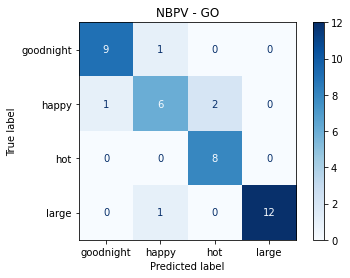

PCA inputs
       EMG0L     EMG0L     EMG0L  ...        GZR        GZR        GZR
83  0.169902  -0.18024 -0.170346  ...   0.428707   0.441722    0.40421
45  0.161495 -0.171322 -0.153632  ...   0.463441   0.465081   0.465572
99  0.177992 -0.188823 -0.207927  ...   0.428788   0.398985   0.390741
40  0.204589 -0.217038  -0.20941  ...   0.629171   0.600183   0.585598
17  0.141928 -0.150565 -0.141923  ...   0.439695   0.439528   0.437366
..       ...       ...       ...  ...        ...        ...        ...
11  0.193853 -0.205649 -0.190667  ...    0.52494   0.520905   0.519775
18  0.122052 -0.129479 -0.123436  ...  0.0289459  0.0686705  0.0635641
74   0.19827 -0.210335 -0.204024  ...   0.243428    0.36303   0.382782
90  0.214934 -0.228013 -0.213081  ...   0.420327   0.419523   0.434387
27  0.226063 -0.239819 -0.230144  ...   0.604709   0.592196   0.574909

[92 rows x 1400 columns]
        EMG0L     EMG0L      EMG0L  ...       GZR       GZR       GZR
106  0.179948 -0.190898   -0.21611  ...  

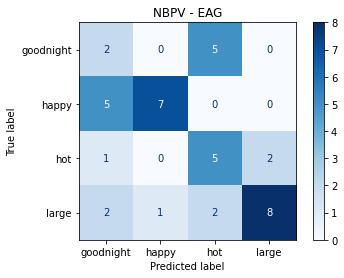

PCA inputs
        EMG0L     EMG0L     EMG0L  ...       OYR       OYR        OYR
71   0.150609 -0.159773  -0.15498  ...  0.037594  0.037594   0.037594
103   0.17869 -0.189564 -0.189714  ...  0.994318         0  0.0227273
82   0.162632 -0.172529 -0.161767  ...    0.4375   0.40625      0.375
80   0.221383 -0.234855 -0.214203  ...  0.372093  0.372093   0.372093
12   0.157788 -0.167389 -0.151346  ...  0.886076  0.886076   0.886076
..        ...       ...       ...  ...       ...       ...        ...
72   0.187485 -0.198894 -0.191524  ...     0.016     0.016      0.016
76   0.180649 -0.191641 -0.180337  ...  0.708661  0.708661   0.708661
67   0.164106 -0.174092 -0.163934  ...  0.779661  0.774011   0.774011
87   0.215348 -0.228453 -0.216205  ...  0.865922  0.871508   0.871508
102  0.184077 -0.195279 -0.193223  ...  0.921348  0.955056          1

[92 rows x 1400 columns]
        EMG0L     EMG0L      EMG0L  ...        OYR        OYR         OYR
47   0.189636 -0.201176  -0.189847  ...        0.

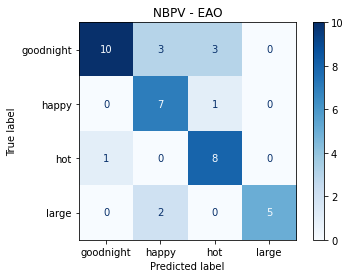

PCA inputs
        EMG0L     EMG0L     EMG0L  ...        OYR        OYR        OYR
123  0.159006 -0.168682  -0.16114  ...   0.546392   0.546392   0.546392
57    0.16356 -0.173513 -0.154459  ...   0.962963   0.975309   0.975309
53   0.214784 -0.227854 -0.211254  ...   0.906977   0.891473   0.875969
113  0.202349 -0.214662 -0.185909  ...    0.19403   0.208955   0.208955
89   0.142774 -0.151462 -0.140428  ...   0.428571   0.428571   0.428571
..        ...       ...       ...  ...        ...        ...        ...
42   0.190128 -0.197652 -0.203431  ...   0.444444   0.444444   0.444444
75    0.22465  -0.23832 -0.217503  ...   0.685039   0.685039   0.685039
70    0.17495 -0.185595 -0.170553  ...  0.0252101  0.0168067  0.0168067
74    0.19827 -0.210335 -0.204024  ...      0.704      0.696      0.696
79   0.154007 -0.163379 -0.136328  ...   0.380952   0.380952   0.380952

[92 rows x 1400 columns]
        EMG0L     EMG0L     EMG0L  ...        OYR        OYR         OYR
91   0.160013  -0.16975 -0

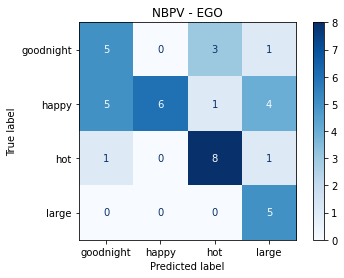

PCA inputs
          AXL       AXL       AXL  ...        OYR        OYR        OYR
87   0.389432  0.392009  0.394844  ...   0.865922   0.871508   0.871508
50   0.353651   0.31196  0.316561  ...   0.484848   0.484848   0.484848
111  0.249638  0.317684  0.477767  ...   0.918605   0.918605   0.918605
37   0.781616  0.757788  0.555903  ...  0.0338983  0.0338983  0.0338983
83   0.299805  0.301198  0.301476  ...   0.387097   0.370968    0.33871
..        ...       ...       ...  ...        ...        ...        ...
106  0.301627  0.323235  0.467811  ...   0.794643   0.794643   0.803571
52   0.490321  0.543001  0.528854  ...   0.888889   0.880952   0.873016
61   0.135257  0.139073  0.131441  ...   0.144144   0.144144   0.144144
19   0.414996  0.412847  0.522924  ...   0.865922   0.860335   0.854749
14   0.211361  0.200115  0.165225  ...   0.546875   0.546875   0.546875

[92 rows x 900 columns]
            AXL         AXL        AXL  ...        OYR        OYR        OYR
74    0.0151061   0.015

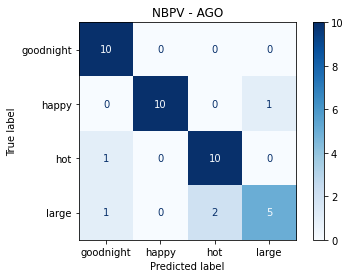

PCA inputs
        EMG0L     EMG0L     EMG0L  ...        OYR        OYR         OYR
73   0.241246 -0.255926 -0.240223  ...   0.677966   0.677966    0.677966
115  0.166691 -0.176834 -0.155476  ...   0.246154   0.230769    0.230769
125  0.146765 -0.155696 -0.141231  ...    0.96648    0.96648    0.960894
31   0.247211 -0.262254 -0.253037  ...   0.407407   0.407407    0.407407
36   0.176579 -0.187325 -0.179328  ...  0.0512821  0.0512821   0.0512821
..        ...       ...       ...  ...        ...        ...         ...
30   0.167095 -0.177263 -0.167981  ...   0.367089   0.367089    0.367089
28   0.159694 -0.169411 -0.153743  ...  0.0733945  0.0642202   0.0458716
39   0.202515 -0.214839 -0.203934  ...  0.0178571  0.0178571  0.00892857
50   0.171146 -0.181561 -0.168334  ...   0.484848   0.484848    0.484848
49   0.155543 -0.165008 -0.152987  ...   0.424658   0.424658    0.424658

[92 rows x 1700 columns]
        EMG0L     EMG0L      EMG0L  ...        OYR        OYR        OYR
118  0.209819 

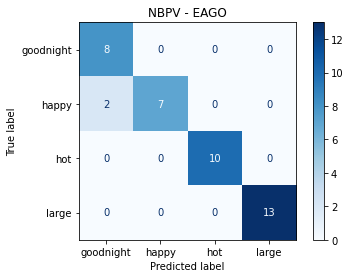

PCA inputs
           EMG0L        EMG0L      EMG0L  ...      EMG7R      EMG7R      EMG7R
81     0.0253906   -0.0269357 -0.0538264  ...    1.08658   0.879842   0.823421
12    -0.0123191    0.0130687  0.0727644  ...     1.7176    1.16574  -0.562486
33     0.0286615   -0.0304056  -0.179705  ...  -0.142844   0.465462  0.0368427
129    0.0421715   -0.0447377   0.361026  ... -0.0317093   0.195988   0.175021
53     0.0439243   -0.0465971 -0.0432025  ...  -0.187724   0.484125  -0.209058
..           ...          ...        ...  ...        ...        ...        ...
63     0.0168648   -0.0178911   0.246241  ...   0.118571    0.18427  -0.251109
34     0.0269607   -0.0286013  -0.288099  ...  -0.129313   0.719581   0.130594
21     0.0505746   -0.0536521  -0.100509  ...  -0.366177  -0.154194  -0.136874
60   0.000389421 -0.000413117  -0.072276  ...    1.37086  0.0661517  -0.379697
59     0.0367677   -0.0390051 -0.0361636  ...  0.0130768   0.188273  -0.243525

[92 rows x 800 columns]
          EMG0L 

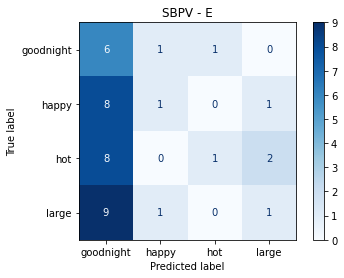

PCA inputs
          AXL        AXL        AXL  ...       AZR      AZR      AZR
52  -0.341904 -0.0949827  -0.161293  ...   1.09164  1.16755  1.16231
11   -1.64156   -1.70715   -1.44665  ...   1.17595  1.20551  1.19443
65  -0.677497   -1.40471  -0.417445  ...   1.08759  1.11172  1.12418
112 -0.735605  -0.720133 -0.0333336  ...   1.09099   1.1056  1.08239
5   -0.326053  -0.326053  -0.602496  ...   1.39331  1.31112  1.31673
..        ...        ...        ...  ...       ...      ...      ...
99   -1.43477   -1.42176   -1.40504  ...  0.907991  1.11142  1.12722
130  -1.96682   -1.99288   -1.28823  ...   1.49805  1.58434  1.48906
103  0.343857   0.359631   0.375407  ...   1.62661  1.19321   1.4041
41   -1.73749   -1.76031   -1.98023  ...  0.990707   1.0571  1.07992
94   0.839235   0.844154   0.809715  ...   1.33369  1.53418   1.5932

[92 rows x 300 columns]
          AXL       AXL        AXL  ...       AZR       AZR       AZR
15  -0.717517 -0.719457  -0.568097  ...   1.40248    1.3792   1.39

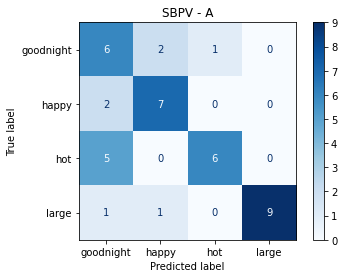

PCA inputs
           GXL          GXL        GXL  ...         GZR         GZR         GZR
123 -0.0166072  0.000449267  -0.380763  ...    -1.04426   -0.725303   -0.219579
50    0.335709   -0.0515342   -0.13609  ...    0.374923    0.300171   0.0538547
25   -0.494085    -0.760814    0.48985  ...  -0.0647774   -0.109656  -0.0969543
108    1.05306      2.08614   0.268014  ...    0.237328  -0.0235001   -0.100214
24  -0.0539832    -0.049469   -1.12113  ...  -0.0720398  -0.0377322  -0.0720398
..         ...          ...        ...  ...         ...         ...         ...
60   -0.761737     -1.01807  -0.585506  ...   -0.486176    -0.37483   -0.324364
9       1.3053      1.73655    1.74635  ...  -0.0301141   -0.037465  0.00786541
93   0.0480177    0.0199919 -0.0478602  ...  0.00376636   -0.362045   -0.525775
114   -1.05068    0.0909842  -0.359834  ...     1.27265     1.34958      1.2588
128     1.0264     0.652686   0.849565  ...   -0.392562 -0.00381583  -0.0904425

[92 rows x 300 columns]
    

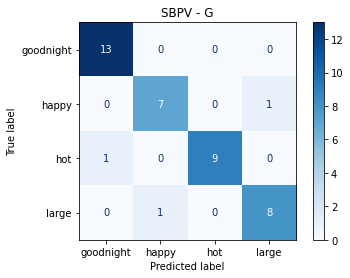

PCA inputs
          ORL       ORL       ORL  ...       OYR       OYR       OYR
26  -0.546733 -0.546733 -0.579361  ...   -1.3298   -1.3298   -1.3298
59  -0.262935 -0.341189 -0.380316  ...   -1.9454  -1.98453  -2.02366
85   -1.01543  -1.01543  -1.01543  ...   1.65522   1.62619   1.59716
36   0.304023  0.238548  0.238548  ...  -1.92214  -1.92214  -1.92214
61  -0.206048 -0.206048 -0.206048  ...  -1.45159  -1.45159  -1.45159
..        ...       ...       ...  ...       ...       ...       ...
62  -0.141583 -0.224703 -0.307824  ...  -1.76244    -1.804  -1.84556
103 -0.462743 -0.488827 -0.488827  ...   2.09356  -2.47126  -2.36693
44    0.38449   0.38449  0.321008  ... -0.377295 -0.377295 -0.377295
68  -0.620298 -0.653054 -0.653054  ...  0.919255  0.919255  0.919255
22  -0.786832 -0.786832 -0.786832  ...   2.37789   2.32237   2.23909

[92 rows x 300 columns]
            ORL         ORL         ORL  ...       OYR       OYR       OYR
117   -0.978137   -0.978137   -0.978137  ...  0.548612  0.579

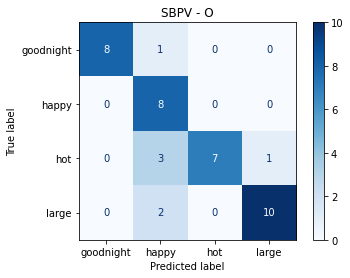

PCA inputs
           EMG0L        EMG0L       EMG0L  ...       AZR       AZR       AZR
125    0.0258403   -0.0274127   0.0117646  ...   1.01443   1.02037  0.972866
60   0.000389421 -0.000413117   -0.072276  ...   1.45219   1.44116    1.4844
54    0.00365358  -0.00387591 -0.00359355  ...  0.855627  0.967804    1.0765
129    0.0421715   -0.0447377    0.361026  ...  0.975855  0.942934   1.00255
81     0.0253906   -0.0269357  -0.0538264  ...   1.23227   1.24313   1.23728
..           ...          ...         ...  ...       ...       ...       ...
107    0.0533429   -0.0565889    -1.06936  ...   2.04168   1.07626  0.608461
16      0.040722      -0.0432   0.0982222  ...   1.31519    1.4508   1.38686
80      0.029955   -0.0317778   0.0269231  ...   1.36259   1.37476   1.36462
85     0.0511171   -0.0542277   -0.125449  ...   1.37527   1.40144   1.47735
34     0.0269607   -0.0286013   -0.288099  ...  0.866574  0.843068  0.892039

[92 rows x 1100 columns]
          EMG0L       EMG0L        EMG0

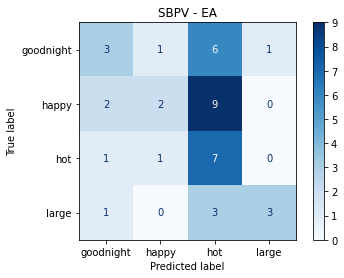

PCA inputs
           EMG0L        EMG0L      EMG0L  ...         GZR         GZR         GZR
122    0.0386176   -0.0409675   0.354074  ...   -0.550735   -0.259138   -0.270875
17     0.0533882   -0.0566369 -0.0889845  ...  -0.0585812  -0.0599831  -0.0782079
67     0.0601224   -0.0637809  -0.100244  ...   -0.667272   -0.446694   -0.140466
91     0.0252796   -0.0268179 -0.0528749  ...  -0.0639662   -0.196035 -0.00817836
73     0.0649432    -0.068895   -0.11845  ... -0.00129975  -0.0433121  -0.0271535
..           ...          ...        ...  ...         ...         ...         ...
31     0.0645838   -0.0685138  -0.185092  ...  -0.0662576   -0.112851  -0.0481379
106    0.0687636   -0.0729479   -0.51524  ...   0.0215695   0.0954299   0.0496686
46     0.0348214   -0.0369403   -1.57797  ...  -0.0196374  0.00565868  -0.0112054
60   0.000389421 -0.000413117  -0.072276  ...   -0.486176    -0.37483   -0.324364
112  -0.00917987   0.00973848  -0.380052  ...   0.0237823   0.0601372   0.0379203

[92 

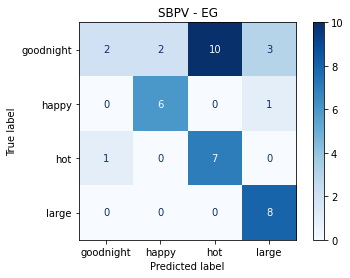

PCA inputs
          EMG0L       EMG0L      EMG0L  ...       OYR       OYR       OYR
85    0.0511171  -0.0542277  -0.125449  ...   1.65522   1.62619   1.59716
10     0.044099  -0.0467825   -0.27624  ... -0.590675 -0.590675 -0.590675
57    0.0193365  -0.0205131   0.036726  ...   1.36774   1.41307   1.41307
43    0.0456079  -0.0483832  -0.371212  ... -0.322756 -0.322756 -0.322756
102 -0.00592548  0.00628605  -0.111945  ...   1.57482   1.72882   1.93415
..          ...         ...        ...  ...       ...       ...       ...
72    0.0416108  -0.0441428  -0.138452  ...  -1.99894  -1.99894  -1.99894
33    0.0286615  -0.0304056  -0.179705  ...   1.19936   1.16218   1.16218
97    0.0236726  -0.0251131  -0.064364  ...   2.00857   2.00857   2.03338
50    0.0333779   -0.035409 -0.0328294  ... -0.210028 -0.210028 -0.210028
32    0.0640296  -0.0679259  -0.225722  ... -0.401328 -0.401328 -0.401328

[92 rows x 1100 columns]
           EMG0L        EMG0L      EMG0L  ...       OYR       OYR       OYR

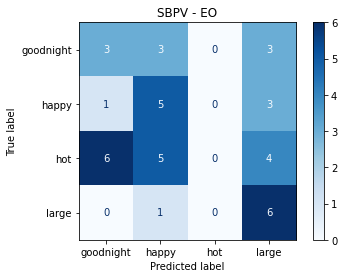

PCA inputs
          AXL       AXL       AXL  ...         GZR         GZR        GZR
104  0.611563  0.408966  0.534971  ...    0.557906    0.264829   0.141951
48   -0.61941 -0.616025 -0.781907  ...   0.0583887    0.204517   0.231621
69   0.435271  0.482433  0.339984  ...  -0.0474973  -0.0275795 -0.0275795
16  -0.651049 -0.761469 -0.748877  ...   0.0658746 -0.00090495 -0.0618776
3    -1.96832  -1.94968  -1.55641  ...  -0.0455998  -0.0526632 -0.0617448
..        ...       ...       ...  ...         ...         ...        ...
131  -1.22236  -1.14231 -0.670497  ...    0.407253    0.308662 -0.0271194
83  -0.497369 -0.493208 -0.492376  ...    -0.81508    -0.69225   -1.04629
85  -0.442967 -0.435987 -0.451691  ...   -0.347785    -1.08366   -1.38703
43  -0.938534 -0.409902 -0.165491  ... -0.00147776   0.0158322  0.0148705
8   -0.829874 -0.790173 -0.689535  ...  -0.0823678  -0.0673005 -0.0615054

[92 rows x 600 columns]
           AXL         AXL        AXL  ...         GZR         GZR         G

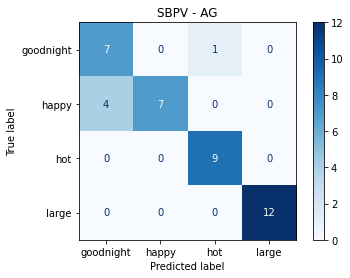

PCA inputs
          AXL       AXL       AXL  ...       OYR        OYR       OYR
68   -1.32384   -1.3153  -1.32299  ...  0.919255   0.919255  0.919255
100  -1.68135  -1.62231  -1.40674  ...   1.27875    1.27875   1.27875
36   -1.63017  -1.84464   -1.8508  ...  -1.92214   -1.92214  -1.92214
8   -0.829874 -0.790173 -0.689535  ... -0.730929  -0.730929 -0.730929
23  -0.460158 -0.215728  -0.73099  ...  -1.55125   -1.55125  -1.55125
..        ...       ...       ...  ...       ...        ...       ...
10   -1.75475  -1.56866  -1.21427  ... -0.590675  -0.590675 -0.590675
47  -0.507835 -0.554213 -0.468912  ...  0.201526  0.0328066 -0.135913
103  0.343857  0.359631  0.375407  ...   2.09356   -2.47126  -2.36693
18  -0.564489 -0.558255 -0.572503  ...   2.03814    1.95259   1.89556
91   -0.72502 -0.721518 -0.676872  ... -0.192226  -0.192226 -0.192226

[92 rows x 600 columns]
           AXL       AXL        AXL  ...        OYR        OYR        OYR
46    -2.28983  -1.56024  -0.469099  ...  -0.66893

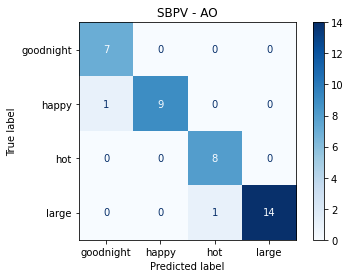

PCA inputs
          GXL        GXL         GXL  ...       OYR       OYR       OYR
8     1.53447    1.35134     0.83326  ... -0.730929 -0.730929 -0.730929
21   0.439752   0.444897    0.474483  ...   1.91111   1.85548   1.79985
59  -0.975619  -0.660253   -0.847246  ...   -1.9454  -1.98453  -2.02366
32   0.452322   0.529331    0.205365  ... -0.401328 -0.401328 -0.401328
117  0.078394  0.0893286    0.468759  ...  0.548612  0.579147  0.670752
..        ...        ...         ...  ...       ...       ...       ...
111  0.156477  -0.433711 -0.00420753  ...   1.71286   1.71286   1.71286
55  -0.165163  -0.166818   -0.206536  ...   1.26152    1.1691   1.07668
116  -0.23057  -0.478733   -0.740877  ...  -1.52201  -1.44614  -1.37027
33    1.88169    2.60792    0.354391  ...   1.19936   1.16218   1.16218
62  -0.629111    -1.0384    -1.32244  ...  -1.76244    -1.804  -1.84556

[92 rows x 600 columns]
             GXL         GXL         GXL  ...       OYR       OYR       OYR
56       0.14137    0.13

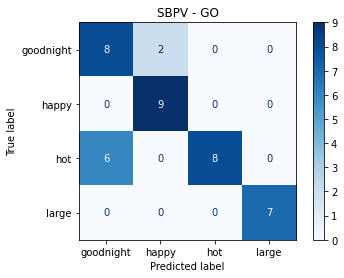

PCA inputs
          EMG0L       EMG0L      EMG0L  ...         GZR        GZR        GZR
38   0.00933139 -0.00989921  -0.061842  ...   0.0344663  0.0418761   0.151965
120   0.0296039  -0.0314053 -0.0727729  ...     1.84925    1.72132    1.47881
43    0.0456079  -0.0483832  -0.371212  ... -0.00147776  0.0158322  0.0148705
105   0.0377271  -0.0400228  -0.605832  ...     1.49458    1.15038   0.363407
87    0.0140799  -0.0149367 -0.0851394  ...    0.663334    1.03532    0.92951
..          ...         ...        ...  ...         ...        ...        ...
86    0.0258381  -0.0274103  -0.087862  ...    0.802475    0.26416 -0.0524964
63    0.0168648  -0.0178911   0.246241  ...   -0.400492   0.101742   0.222563
50    0.0333779   -0.035409 -0.0328294  ...    0.374923   0.300171  0.0538547
97    0.0236726  -0.0251131  -0.064364  ...    -0.54146  -0.521741   0.343291
124   0.0160324   -0.017008   0.170114  ...  -0.0469813 -0.0530888 -0.0391288

[92 rows x 1400 columns]
          EMG0L       EMG0L

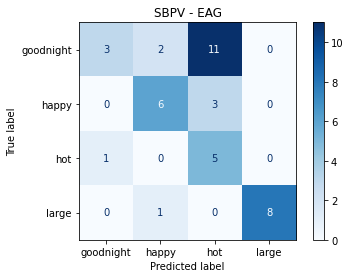

PCA inputs
         EMG0L      EMG0L      EMG0L  ...       OYR       OYR       OYR
73   0.0649432  -0.068895   -0.11845  ...  0.543318  0.543318  0.543318
77   0.0113353 -0.0120251   0.688748  ...  -2.36596  -2.36596  -2.36596
30   0.0375673 -0.0398533 -0.0854239  ... -0.717748 -0.717748 -0.717748
85   0.0511171 -0.0542277  -0.125449  ...   1.65522   1.62619   1.59716
17   0.0533882 -0.0566369 -0.0889845  ...  0.347844  0.347844  0.347844
..         ...        ...        ...  ...       ...       ...       ...
94   0.0122775 -0.0130246 -0.0912854  ...  -1.80304  -1.80304   2.12154
2    0.0219745 -0.0233117 -0.0995717  ...  0.955416  0.955416  0.917189
72   0.0416108 -0.0441428  -0.138452  ...  -1.99894  -1.99894  -1.99894
20    0.050004 -0.0530468 -0.0491823  ...   1.77617   1.71982   1.69165
131  0.0287115 -0.0304586  -0.231807  ...    2.1187    2.1187    2.1187

[92 rows x 1400 columns]
          EMG0L       EMG0L       EMG0L  ...       OYR        OYR       OYR
98    0.0468152   -0.04

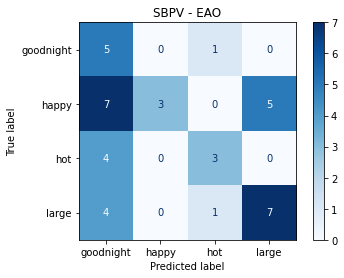

PCA inputs
          EMG0L       EMG0L      EMG0L  ...       OYR        OYR       OYR
102 -0.00592548  0.00628605  -0.111945  ...   1.57482    1.72882   1.93415
59    0.0367677  -0.0390051 -0.0361636  ...   -1.9454   -1.98453  -2.02366
47    0.0346787   -0.036789 -0.0841413  ...  0.201526  0.0328066 -0.135913
7     0.0539641  -0.0572479    1.03233  ...  -1.83438   -1.83438  -1.83438
33    0.0286615  -0.0304056  -0.179705  ...   1.19936    1.16218   1.16218
..          ...         ...        ...  ...       ...        ...       ...
25   0.00680263 -0.00721657  -0.177519  ...  -1.36394   -1.36394  -1.36394
129   0.0421715  -0.0447377   0.361026  ...   2.12686    2.12686   2.12686
24    0.0637868  -0.0676683  -0.192321  ...  -1.54282   -1.54282  -1.54282
37   -0.0109027   0.0115662    0.13975  ...  -1.97271   -1.97271  -1.97271
95    0.0472768  -0.0501537 -0.0958753  ...   1.92137    1.92137   1.92137

[92 rows x 1400 columns]
          EMG0L       EMG0L       EMG0L  ...       OYR       OY

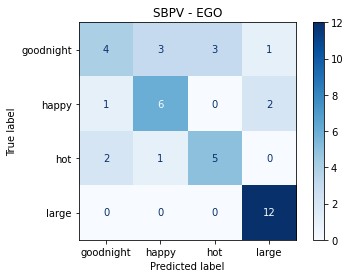

PCA inputs
          AXL       AXL       AXL  ...       OYR       OYR       OYR
127  0.840803  0.859595  0.912394  ...   2.03727   2.00964     1.982
64   0.885556  0.964881  0.952939  ...   1.96629   1.96629   1.96629
4   -0.169903 -0.103515  0.311655  ...  -1.74648  -1.74648  -1.74648
16  -0.651049 -0.761469 -0.748877  ... -0.109504 -0.109504 -0.109504
75   -1.17681  -1.17851    -1.164  ...  0.725525  0.725525  0.725525
..        ...       ...       ...  ...       ...       ...       ...
35   -1.79295  -1.75521  -2.08358  ...   1.39445   1.35818   1.32191
90  -0.754113 -0.754113 -0.705051  ... -0.171175 -0.171175 -0.171175
100  -1.68135  -1.62231  -1.40674  ...   1.27875   1.27875   1.27875
66   -1.33558  -1.30345  -1.31648  ...   1.27895   1.27895   1.27895
12   -1.00851  -1.04956  -1.13164  ...   1.50138   1.50138   1.50138

[92 rows x 900 columns]
           AXL         AXL        AXL  ...        OYR        OYR        OYR
48    -0.61941   -0.616025  -0.781907  ... -0.0319721 -0.031

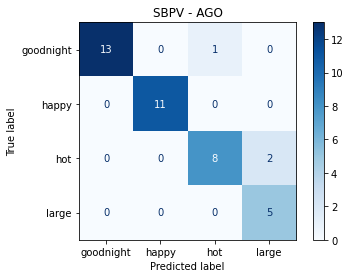

PCA inputs
          EMG0L       EMG0L       EMG0L  ...       OYR       OYR       OYR
111   0.0304616  -0.0323152   0.0161492  ...   1.71286   1.71286   1.71286
98    0.0468152   -0.049664   -0.181009  ...   1.99172   1.99172   1.99172
14    0.0520899  -0.0552596   -0.051234  ...  -0.28236  -0.28236  -0.28236
52    0.0338644  -0.0359251  -0.0581626  ...   1.89936    1.8712   1.84303
83   0.00553929 -0.00587636  -0.0455517  ... -0.609738 -0.665678 -0.777556
..          ...         ...         ...  ...       ...       ...       ...
128   0.0234149  -0.0248398    0.322115  ...   2.15832   2.15832   2.18419
130   0.0508916  -0.0539885   -0.429962  ...   1.93674   1.99201   2.01965
109   0.0218862  -0.0232181     1.24929  ...   1.64563   1.61903   1.61903
70    0.0332021  -0.0352225 -0.00515995  ...  -1.93481  -1.96662  -1.96662
81    0.0253906  -0.0269357  -0.0538264  ... -0.150788 -0.202904 -0.202904

[92 rows x 1700 columns]
          EMG0L       EMG0L        EMG0L  ...       OYR        

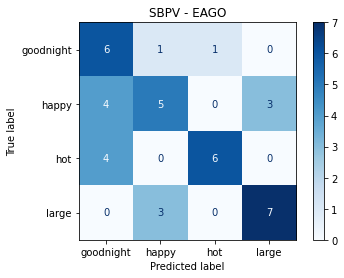

In [12]:
for st in steps:
  rownum+=1
  columnnum=-1
  for pr in regproducts:
    columnnum+=1
    combo=nsteps[rownum]+' - '+comb[columnnum]
    words=set(pr['Word']) # Obtain the target names for the SVM
    
    # First step: set input matrix as regular, normalized or standardized
    input_matrix=pr
    if st%3==0: # Normalization
      input_matrix=normproducts[columnnum]
    if st%5==0: # Standardization
      input_matrix=stanproducts[columnnum]
    
    # Second step: apply Butterworth
    two_matrix=input_matrix
    if st%7==0: # Butterworth
      two_matrix=butterworth(input_matrix)
    
    # Third step: split data for later steps
    x_train, x_test, y_train, y_test=datasplit(two_matrix)
    
    # Fourth step: apply PCA
    x_t_train=x_train
    x_t_test=x_test
    if st%11==0: # PCA
      x_train, x_test, y_train, y_test, x_t_train, x_t_test=pca(x_train, x_test, y_train, y_test)
    
    # Fifth step: apply SVM
    if st%13==0: # SVM
      #svmresults,accuracy,par=svm(x_train, x_test, y_train, y_test, x_t_train, x_t_test,combo)
      svmresults,accuracy=svm(x_train, x_test, y_train, y_test, x_t_train, x_t_test,combo)
    
    #print('The best parameters for',combo,'are:',par)
    fresults[rownum,columnnum]=accuracy*100
fresults=pd.DataFrame(fresults,index=nsteps,columns=comb)
exec("fresults.to_csv(path_or_buf='/content/results_'+str(numreps)+'.csv')")

endtime=time.time()

# **5. Results**

In [13]:
print(fresults)
print('The maximum accuracy for',numreps,'repetitions is',fresults.max().max())
print('The program executed in '+str(endtime-starttime)+' seconds')

          E      A      G      O     EA  ...    EAG    EAO    EGO    AGO   EAGO
V     22.00  49.75  67.00  49.75  46.75  ...  41.50  13.75  55.75  58.25  38.75
NV    36.50  44.50  53.00  52.75  36.00  ...  50.00  58.50  56.00  47.25  49.50
SV    13.75  28.50  63.75  30.50  17.00  ...  44.25  19.75  19.50  60.75  36.25
BV    30.50  58.25  66.50  52.50  33.50  ...  41.75  36.25  33.50  52.50  52.50
PV    25.00  61.25  55.75  39.00  41.75  ...  60.75  47.25  69.50  58.50  72.25
NBV   20.25  41.75  53.00  58.25  22.25  ...  17.50  19.25  49.75  38.75  42.00
NPV   13.75  50.00  63.75  56.00  63.75  ...  71.75  58.00  52.25  52.50  55.50
SBV   11.25  39.00  64.00  47.00  30.25  ...  16.75  16.75  33.25  50.25  33.00
SPV   16.75  58.50  60.75  55.25  39.25  ...  49.75  63.25  47.00  52.50  58.25
BPV   27.50  52.75  63.75  49.75  28.25  ...  61.25  41.50  63.75  58.25  47.25
NBPV  30.75  55.25  67.00  50.25  47.00  ...  52.75  58.50  38.75  67.00  58.50
SBPV  25.00  52.50  53.00  46.75  24.75 